# Feature Engineering
An all-in-one comprehensive notebook for engineering hundreds (if not thousands, maybe) features for the *Kaggle Sberbank Competition*.

**Notes:**
- Remember to rerun this notebook with different values for `useful_label_cols`. Be sure to run it at least with `LABEL`, `LABEL + '_log'`, and `LABEL + '_sqrt'` This is important, because running them all at the same time hangs the computer and the notebook runs out of memory. ;( Wa, wa, wa...
- After this step, remember to try to predict these different target variables using different models to find the model that produces the best performance (aka. lowest RMSLE)

## Imports

In [1]:
import pandas as pd, numpy as np, seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

## Import data

In [3]:
train_df = pd.read_csv("../data/train.csv/train.csv", index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv("../data/test.csv/test.csv", index_col='id', parse_dates=['timestamp'])
macro_df = pd.read_csv("../data/macro.csv/macro.csv", parse_dates=['timestamp'])

### Incorporate the data fixes into the training set

**Note:** We also need to decide whether we should actually incorporate this updated extra data into the training set when creating and implementing new models...

In [4]:
df_fixup = pd.read_excel('../data/BAD_ADDRESS_FIX.xlsx', index_col='id')

In [5]:
fix_train_indexset = set(df_fixup[df_fixup.index < train_df.index.max()].index)
bad_train_indexset = set(train_df[train_df.kremlin_km == train_df.kremlin_km.min()].index)
unfixed_set = bad_train_indexset.difference(fix_train_indexset)

train_df.drop(unfixed_set, inplace=True)

full_df = pd.concat([train_df, test_df])

In [6]:
for c in df_fixup.columns:
    full_df.loc[df_fixup.index, c] = df_fixup[c]

In [7]:
# Derive training and testing sets back from the fixed full dataframe...
df_fixed = full_df
df_fixed.reset_index(inplace=True)

In [8]:
df_fixed.head()

,id,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,...,water_km,water_treatment_km,work_all,work_female,work_male,workplaces_km,young_all,young_female,young_male,zd_vokzaly_avto_km
0,1,18654,8945,9709,23603,11317,12286,9576,4677,4899,...,0.992631,23.683460,98207,45930,52277,0.884350,21154,10147,11007,14.231961
1,2,13729,6800,6929,17700,8702,8998,6880,3414,3466,...,0.698081,1.317476,70194,34572,35622,0.686252,15727,7802,7925,9.242586
2,3,11252,5336,5916,14884,7063,7821,5879,2784,3095,...,0.468265,4.912660,63388,31575,31813,1.510089,13028,6193,6835,9.540544
3,4,24934,12152,12782,32063,15550,16513,13087,6442,6645,...,1.200336,15.623710,120381,60341,60040,0.622272,28563,13883,14680,17.478380
4,5,11631,5408,6223,15237,7124,8113,5706,2724,2982,...,0.820294,10.683540,68043,33807,34236,0.892668,13368,6209,7159,1.595898


In [9]:
assert df_fixed.shape[0] == train_df.shape[0] + test_df.shape[0]

## Preview data

In [10]:
train_df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [11]:
macro_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,...,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


## Imputation
From a quick glance, it becomes immediately evident that we need to impute the NaN values... So, let's do that now.

There are many ways to go about doing this, but let's follow this approach:

- For the product_type and other *categorical columns*, let's impute it with the **mode** (most common)
- For the *continuous columns* and other variables, let's use a simple **median** to impute their NaN column values

** Note: **
We can also impute the NaN values using pandas's own interpolate functions, which can interpolate linearly, cubically, polynomially, etc.

** TODO: ** Need to evaluate these different imputation methods to find the best one!

In [12]:
impute_with_mode_cols = ['material', 'product_type', 'state', 'ID_'] # The categorical columns in our dataset

### Training + Testing set

In [13]:
exclude_imputation_cols = ['price_doc'] # The testing set obviously has NaN price_doc values, so ignore this intentionally

In [14]:
# Get the columns that have NaN values.
impute_cols = [c for c in df_fixed.columns[df_fixed.isnull().any()].tolist() if c not in exclude_imputation_cols]

In [15]:
df_fixed_imputed = df_fixed.copy()

In [16]:
for col in impute_cols:
    # Check if we should impute this with the mode.
    impute_with_mode = False
    if "ID_" in col:
        impute_with_mode = True
    else:
        impute_with_mode = any(icol == col for icol in impute_with_mode_cols)
    
    if impute_with_mode:
        # Impute this column with the mode.
        mode = df_fixed[col].dropna().mode()[0]
        df_fixed_imputed[col] = df_fixed_imputed[col].fillna(value=mode)
    else:
        # Impute this column with the median.
        median = df_fixed[col].dropna().median()
        df_fixed_imputed[col] = df_fixed_imputed[col].fillna(value=median)

In [17]:
# Everything's cleaned up! ;)
assert len([c for c in df_fixed_imputed.columns[df_fixed_imputed.isnull().any()].tolist() if c not in exclude_imputation_cols]) == 0

### Macroeconomy set

In [18]:
# Get the columns that have NaN values.
impute_cols = [c for c in macro_df.columns[macro_df.isnull().any()].tolist()]

In [19]:
macro_df_imputed = macro_df.copy()

In [20]:
# These columns store numbers as strings (aka. pandas objects) with commas, so they need some cleaning & parsing...
problematic_cols = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']

In [21]:
for c in problematic_cols:
    macro_df_imputed[c].replace('#!', np.nan, inplace=True)
    macro_df_imputed[c] = macro_df_imputed.apply(lambda row: str(row['child_on_acc_pre_school']).replace(",","") if row['child_on_acc_pre_school'] else row['child_on_acc_pre_school'], 1)
    macro_df_imputed[c]  = macro_df_imputed[c].astype(np.float32)

In [22]:
for col in impute_cols:
    # Check if we should impute this with the mode.
    impute_with_mode = False
    if "ID_" in col:
        impute_with_mode = True
    else:
        impute_with_mode = any(icol == col for icol in impute_with_mode_cols)
    
    if impute_with_mode:
        # Impute this column with the mode.
        print 'Imputing column %s with mode.' % col
        mode = macro_df_imputed[col].dropna().mode()[0]
        macro_df_imputed[col] = macro_df_imputed[col].fillna(value=mode)
    else:
        # Impute this column with the median.
        median = macro_df_imputed[col].dropna().median()
        macro_df_imputed[col] = macro_df_imputed[col].fillna(value=median)

In [23]:
# Everything's cleaned up! ;)
assert len( macro_df_imputed.columns[macro_df_imputed.isnull().any()].tolist()) == 0

## Compute some basic features on the fixed dataset

** Notes: **
The 'id' variable is actually important since it contains some time-based information, as discussed in the Kaggle Forumns.
Although this variable cannot be inputed into deep neural networks, they can be harnessed by XGBoost and other gradient boosting models, right?

In [3]:
def save_features_to_disk(df):
    path = "../data/full_features_engineered_with_imputation.csv"
    df.to_csv(path, index=False)

In [4]:
def load_features_df_from_disk():
    return pd.read_csv("../data/full_features_engineered_with_imputation.csv", parse_dates=['timestamp'])

In [25]:
full_df_features = df_fixed_imputed.copy()

In [5]:
full_df_features = load_features_df_from_disk()

### Target variable transformations
Transforming the target variables using functions like log, log(x + 1), exp, etc.

** Note: ** The testing dataset is included in the full dataset, and thus, we should not transform the target variables in the fullset that are null! Only transform the target variables in the fullset that are NOT null, since these values belong to the training set

In [8]:
LABEL = "price_doc"

In [9]:
def extract_label_transformation_cols(df, include_label_col=True):
    global LABEL
    transformed_cols = []
    for c in df.columns.tolist():
        if LABEL in c and "spl_" not in c:
            # This is a label transformation col, because it contains the label keyword but is not a "spl" column
            if c == LABEL:
                if include_label_col:
                    transformed_cols.append(c)
            else:
                transformed_cols.append(c)
    return transformed_cols

In [28]:
full_df_features[LABEL + "_log"] = full_df_features.apply(lambda row: np.log(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [29]:
full_df_features[LABEL + "_log10"] = full_df_features.apply(lambda row: np.log10(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [30]:
full_df_features[LABEL + "_log1p"] = full_df_features.apply(lambda row: np.log1p(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [31]:
full_df_features[LABEL + "_log2"] = full_df_features.apply(lambda row: np.log2(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [32]:
full_df_features[LABEL + "_logaddexp2"] = full_df_features.apply(lambda row: np.logaddexp(row[LABEL], 2) if row[LABEL] else row[LABEL], axis=1)

In [33]:
full_df_features[LABEL + "_square"] = full_df_features.apply(lambda row: np.square(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [34]:
full_df_features[LABEL + "_sqrt"] = full_df_features.apply(lambda row: np.sqrt(row[LABEL]) if row[LABEL] else row[LABEL], axis=1)

In [35]:
full_df_features[LABEL + "_pow3"] = full_df_features.apply(lambda row: np.power(row[LABEL], 3) if row[LABEL] else row[LABEL], axis=1)

In [10]:
label_transform_cols = extract_label_transformation_cols(full_df_features)

#### Preview the distributions of the various target variable transformations

** Note: ** The original target variable distribution is very skewed, whereas some other distributions (e.g. log and sqrt) are more symmetrical

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facaa35f750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faca9a36410>]], dtype=object)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


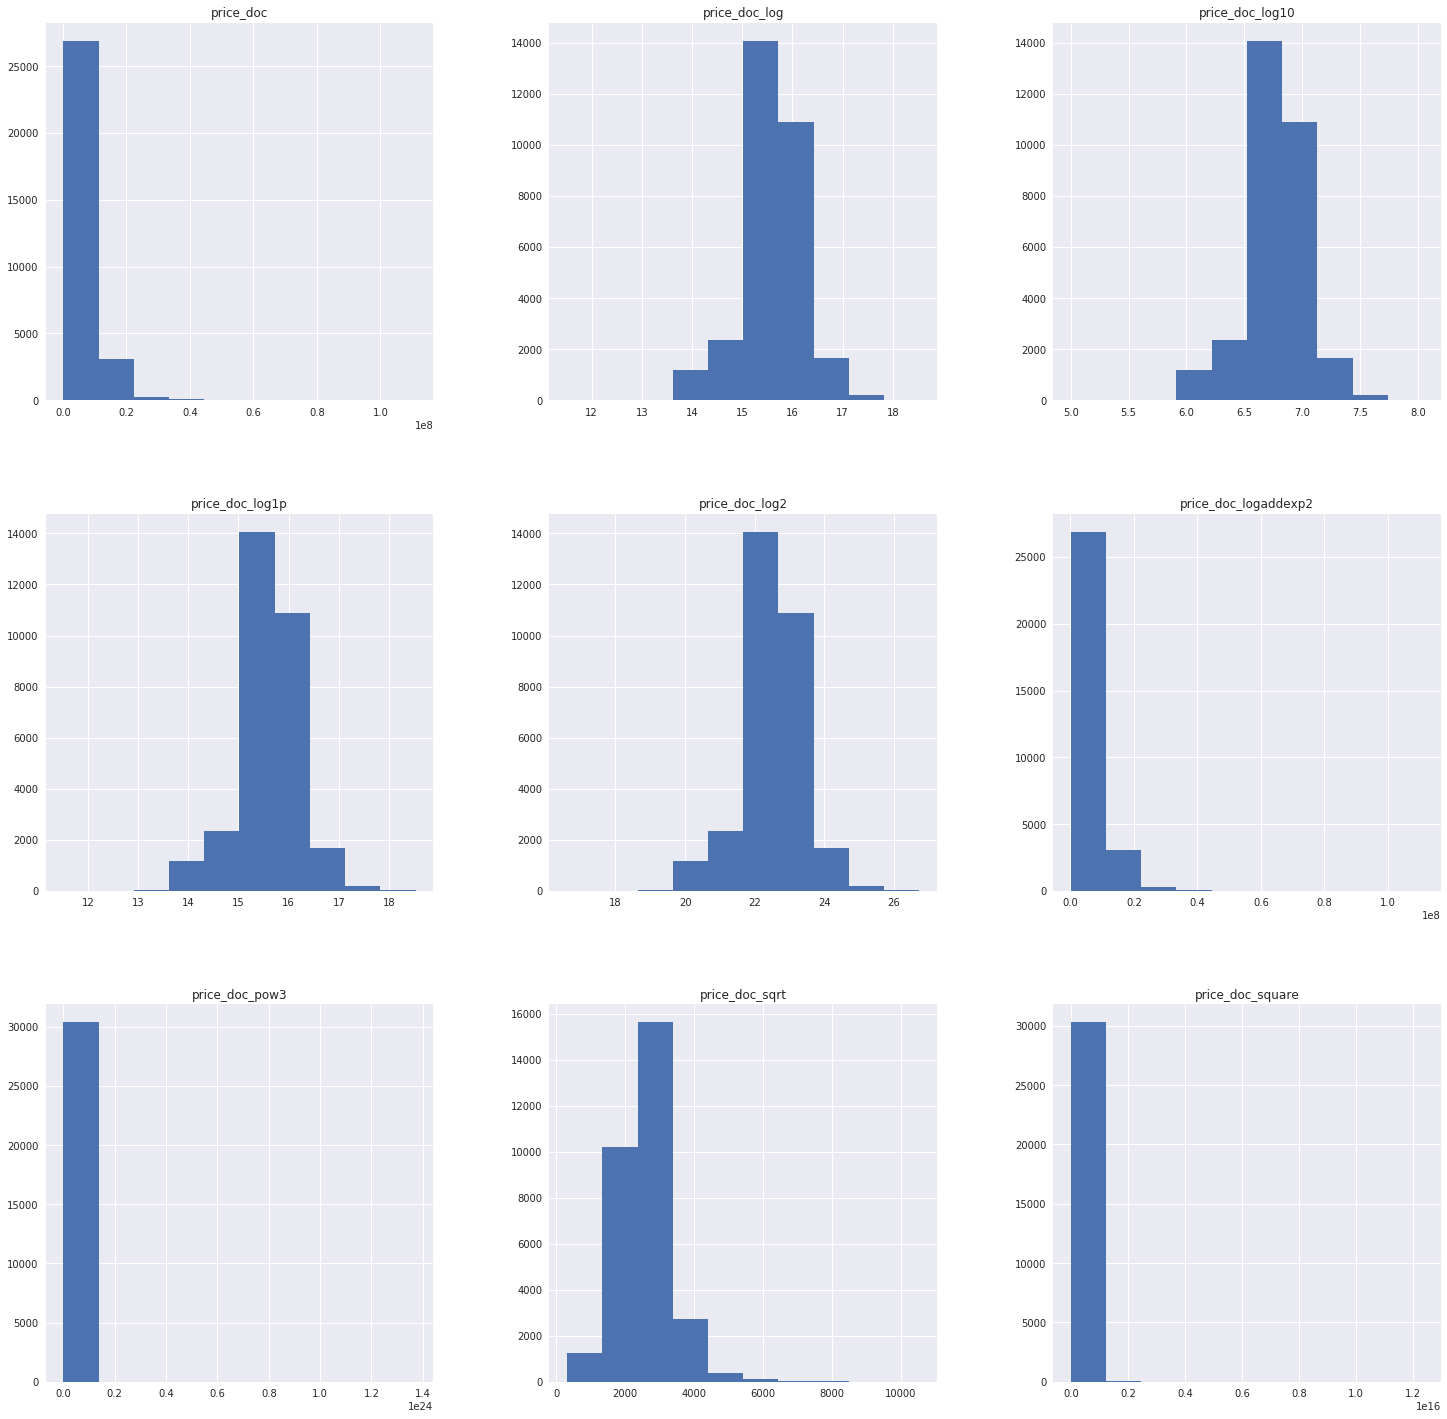

In [11]:
full_df_features[label_transform_cols].hist(figsize = (25, 25))

In [12]:
label_transform_cols

['price_doc',
 'price_doc_log',
 'price_doc_log10',
 'price_doc_log1p',
 'price_doc_log2',
 'price_doc_logaddexp2',
 'price_doc_square',
 'price_doc_sqrt',
 'price_doc_pow3']

In [13]:
# Do the first one below if you have a lot of memory ;)
# useful_label_transform_cols = [LABEL, LABEL + "_log", LABEL + "_sqrt", LABEL + "_log1p", LABEL + "_log2"]
#useful_label_transform_cols = [LABEL, LABEL + "_log"]
useful_label_transform_cols = [LABEL + "_log"]
useful_label_transform_cols

['price_doc_log']

### Remember compute the below relations to target variable with respect to EACH transformed label, not just with the original `price_doc` one...

But due to memory constraints, for now, we're only computing them with respect to the `useful_label_transform_cols`
    - See notebook heading for more info on how to go about this...

In [16]:
def _add_relations_to_target_variable_as_feature(df, cols, label = LABEL):
    
    if type(cols) == str:
        meaned_df = df[df[label].notnull()].groupby(cols, as_index=False)[label].mean().rename(columns={label : 'spl_%s_x_%s_mean' % (cols, label)})
        medianed_df = df[df[label].notnull()].groupby(cols, as_index=False)[label].median().rename(columns={label : 'spl_%s_x_%s_median' % (cols, label)})
        minned_df = df[df[label].notnull()].groupby(cols, as_index=False)[label].min().rename(columns={label : 'spl_%s_x_%s_min' % (cols, label)})
        maxxed_df = df[df[label].notnull()].groupby(cols, as_index=False)[label].max().rename(columns={label : 'spl_%s_x_%s_max' % (cols, label)})
        
        # Also add percentiles
        percentile25_df = df[df[label].notnull()].groupby(cols).quantile(0.25)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile25' % (cols, label)})
        percentile50_df = df[df[label].notnull()].groupby(cols).quantile(0.50)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile50' % (cols, label)})
        percentile75_df = df[df[label].notnull()].groupby(cols).quantile(0.75)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile75' % (cols, label)})
        percentile90_df = df[df[label].notnull()].groupby(cols).quantile(0.90)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile90' % (cols, label)})

        ## Add variance and standard deviations
        variance_df = df[df[label].notnull()].groupby(cols)[label].var().reset_index().rename(columns={label : 'spl_%s_x_%s_var' % (cols, label)})
        std_df = df[df[label].notnull()].groupby(cols)[label].std().reset_index().rename(columns={label : 'spl_%s_x_%s_std' % (cols, label)})
        
        # Merge these datasets with the given dataframe on the specified column
        merged_df = df.merge(meaned_df,on=cols).merge(medianed_df,on=cols).merge(minned_df,on=cols).merge(maxxed_df,on=cols)
        
        # Merge in the quantiles as well
        merged_df = merged_df.merge(percentile25_df, on=cols).merge(percentile50_df, on=cols).merge(percentile75_df, on=cols).merge(percentile90_df, on=cols)
        
        # Merge in variance & standard deviation
        merged_df = merged_df.merge(variance_df, on=cols).merge(std_df, on=cols)

        
        return merged_df
    
    elif type(cols) in (list, tuple):
        merged = False
        for c in cols:
            meaned_df = df[df[label].notnull()].groupby(c, as_index=False)[label].mean().rename(columns={label : 'spl_%s_x_%s_mean' % (c, label)})
            medianed_df = df[df[label].notnull()].groupby(c, as_index=False)[label].median().rename(columns={label : 'spl_%s_x_%s_median' % (c, label)})
            minned_df = df[df[label].notnull()].groupby(c, as_index=False)[label].min().rename(columns={label : 'spl_%s_x_%s_min' % (c, label)})
            maxxed_df = df[df[label].notnull()].groupby(c, as_index=False)[label].max().rename(columns={label : 'spl_%s_x_%s_max' % (c, label)})
        
            # Also add percentiles
            percentile25_df = df[df[label].notnull()].groupby(c).quantile(0.25)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile25' % (c, label)})
            percentile50_df = df[df[label].notnull()].groupby(c).quantile(0.50)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile50' % (c, label)})
            percentile75_df = df[df[label].notnull()].groupby(c).quantile(0.75)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile75' % (c, label)})
            percentile90_df = df[df[label].notnull()].groupby(c).quantile(0.90)[[label]].reset_index().rename(columns={label : 'spl_%s_x_%s_percentile90' % (c, label)})
            
            ## Add variance and standard deviations
            variance_df = df[df[label].notnull()].groupby(c)[label].var().reset_index().rename(columns={label : 'spl_%s_x_%s_var' % (c, label)})
            std_df = df[df[label].notnull()].groupby(c)[label].std().reset_index().rename(columns={label : 'spl_%s_x_%s_std' % (c, label)})
            
            # Merge these datasets with the given dataframe on the specified column
            if not merged:
                merged_df = df.merge(meaned_df,on=c).merge(medianed_df,on=c).merge(minned_df,on=c).merge(maxxed_df,on=c)
                merged = True
            else:
                merged_df = merged_df.merge(meaned_df,on=c).merge(medianed_df,on=c).merge(minned_df,on=c).merge(maxxed_df,on=c)
                
             # Merge in the quantiles as well
            merged_df = merged_df.merge(percentile25_df, on=c).merge(percentile50_df, on=c).merge(percentile75_df, on=c).merge(percentile90_df, on=c)
                    
            # Merge in variance & standard deviation
            merged_df = merged_df.merge(variance_df, on=c).merge(std_df, on=c)

        return merged_df
    else:
        raise ValueError("Inappropriate type passed to the 'cols' parameter: %s" % str(type(cols)))

In [17]:
def add_relations_to_target_variable_as_feature(df, cols, labels = useful_label_transform_cols):
    
    if type(labels) == str:
        return _add_relations_to_target_variable_as_feature(df, cols, labels)
    
    elif type(labels) in (list, tuple):
        processed_df = False
        
        for label_col in useful_label_transform_cols:
            
            if not processed_df:
                merged_df = _add_relations_to_target_variable_as_feature(df, cols, label_col)
                processed_df = True
            else:
                merged_df = _add_relations_to_target_variable_as_feature(merged_df, cols, label_col)
        
        return merged_df
        
    else:
        raise ValueError("Inappropriate type passed to the 'cols' parameter: %s" % str(type(cols)))

In [18]:
def extract_special_columns(df):
    """
    Extract and return the dataframe's columns that are computed with respect to their relation to the target variables.
    These columns have the special keyword 'spl' in them.
    """
    spl_cols = []
    for col in df.columns.tolist():
        if 'spl_' in col:
            spl_cols.append(col)
    return spl_cols

In [19]:
# Note: This operation doesn't modify the given dataframe inplace, but returns a modified dataframe...
# In other words, this function's operations on the given dataframe are immutable
extract_special_columns(add_relations_to_target_variable_as_feature(full_df_features, 'state'))

['spl_timestamp_year_x_price_doc_log_mean',
 'spl_timestamp_year_x_price_doc_log_median',
 'spl_timestamp_year_x_price_doc_log_min',
 'spl_timestamp_year_x_price_doc_log_max',
 'spl_timestamp_year_x_price_doc_log_percentile25',
 'spl_timestamp_year_x_price_doc_log_percentile50',
 'spl_timestamp_year_x_price_doc_log_percentile75',
 'spl_timestamp_year_x_price_doc_log_percentile90',
 'spl_timestamp_year_x_price_doc_log_var',
 'spl_timestamp_year_x_price_doc_log_std',
 'spl_timestamp_isleapyear_x_price_doc_log_mean',
 'spl_timestamp_isleapyear_x_price_doc_log_median',
 'spl_timestamp_isleapyear_x_price_doc_log_min',
 'spl_timestamp_isleapyear_x_price_doc_log_max',
 'spl_timestamp_isleapyear_x_price_doc_log_percentile25',
 'spl_timestamp_isleapyear_x_price_doc_log_percentile50',
 'spl_timestamp_isleapyear_x_price_doc_log_percentile75',
 'spl_timestamp_isleapyear_x_price_doc_log_percentile90',
 'spl_timestamp_isleapyear_x_price_doc_log_var',
 'spl_timestamp_isleapyear_x_price_doc_log_std',


### Time features from timestamp (month, day of week, year, etc.)
Computed separately for the days, weeks, months, and years

In [20]:
unreliable_timestamp_features = [] # Used to store features that, based on analysis should probably not be used. 
# However, it is VERY IMPORTANT to first test ALL features 
# using Linear model coefficients, Random Forests, and XGB regressors to figure out actual feature importance

In [21]:
crossed_feature_suggestions = []

#### Year

In [22]:
full_df_features['timestamp_year'] = full_df_features.apply(lambda row: row['timestamp'].year, axis=1)

In [23]:
# The max year in the dataset is 2015. Test set only contains 2015 days.
# This feature will probably help models better generalize, since years closer to 2016 will have higher prices, etc.
full_df_features['timestamp_yearsuntil2016'] = 2016 - full_df_features['timestamp_year']

In [46]:
full_df_features['timestamp_isleapyear'] = full_df_features.apply(lambda row: row['timestamp'].is_leap_year, axis=1)

In [47]:
full_df_features['timestamp_isquarterstart'] = full_df_features.apply(lambda row: row['timestamp'].is_quarter_start, axis=1)

In [48]:
full_df_features['timestamp_isquarterend'] = full_df_features.apply(lambda row: row['timestamp'].is_quarter_end, axis=1)

In [49]:
full_df_features['timestamp_isyearstart'] = full_df_features.apply(lambda row: row['timestamp'].is_year_start, axis=1)

In [50]:
full_df_features['timestamp_isyearend'] = full_df_features.apply(lambda row: row['timestamp'].is_year_end, axis=1)

In [51]:
# Add the relations of these features to the target variable...
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_year', 'timestamp_isleapyear', 'timestamp_isquarterstart', 'timestamp_isquarterend', 'timestamp_isyearstart', 'timestamp_isyearend'])

#### <center>Analysis + Bucketization + Relations with target variable</center>

<center>How does the price change with respect to the ** *year* **?</center>

**Observations:**
- According to the median price graph, the rate of price change seems to slightly increase at ** *2012* ** and then sharply increase at around ** *2013* **.
- The mean prices are slightly bigger than the median prices due to the outlier
- The split at 2013 only seems to better separate the price values than the split involving 2012 *and* 2013.

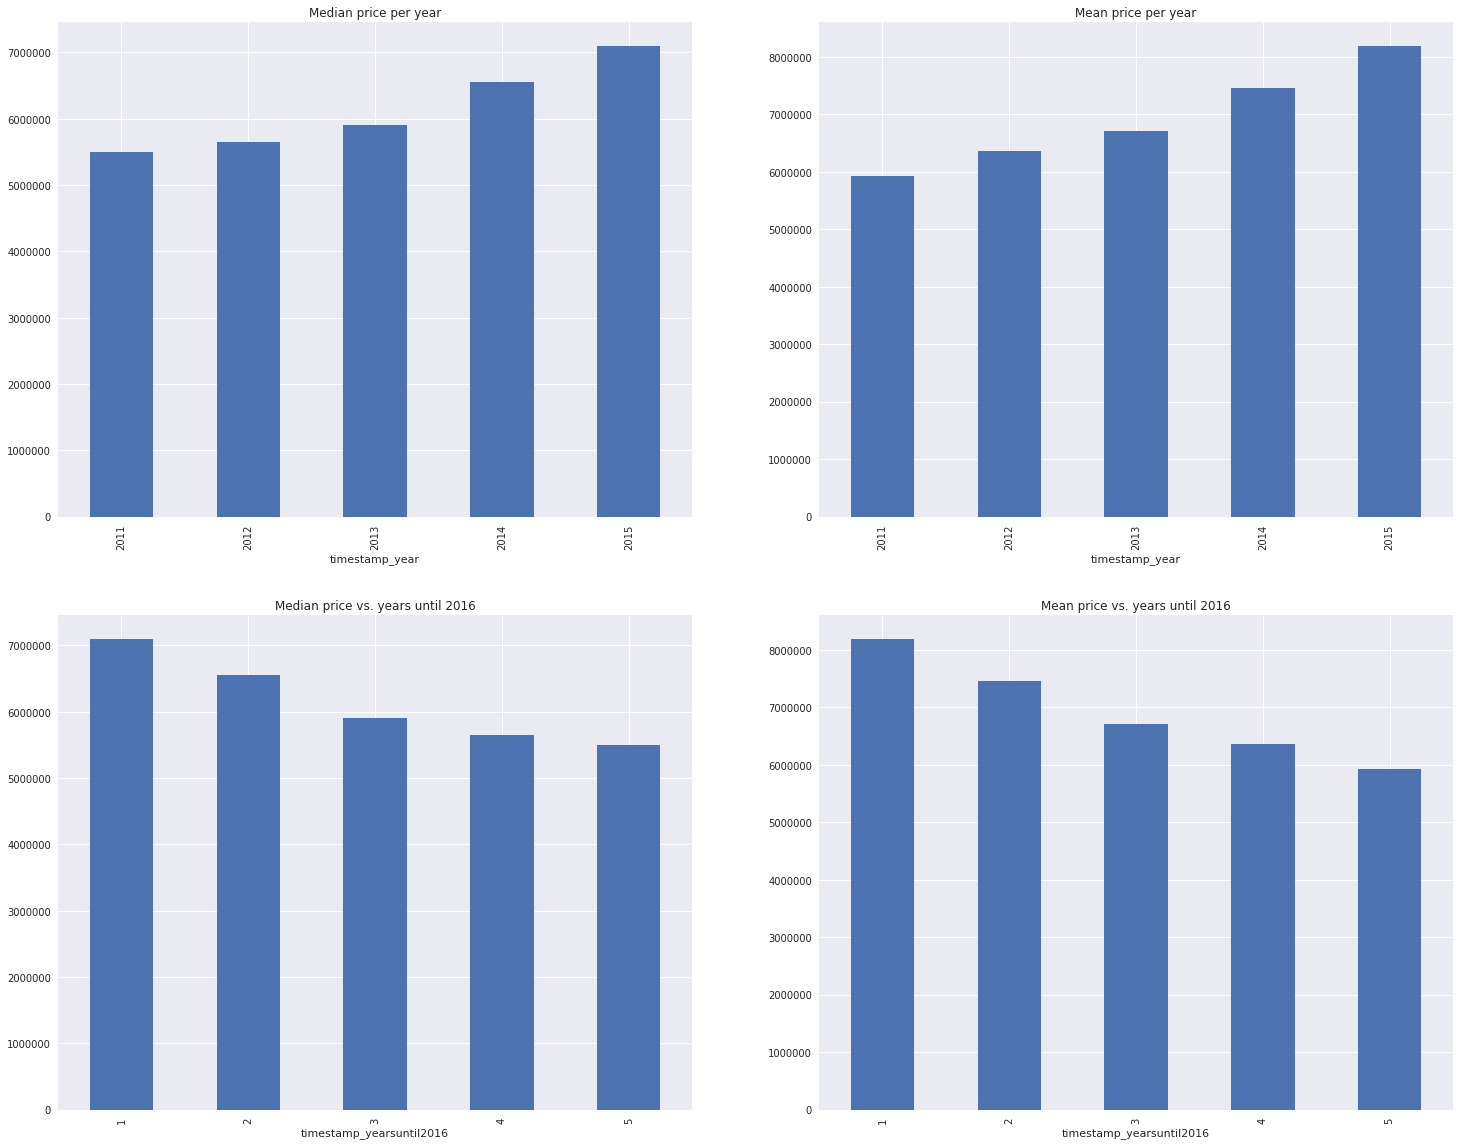

In [28]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(25, 20))
full_df_features.groupby('timestamp_year')[LABEL].median().plot(kind='bar', title='Median price per year', ax=axes[0, 0])
full_df_features.groupby('timestamp_year')[LABEL].mean().plot(kind='bar', title='Mean price per year', ax=axes[0, 1])

full_df_features.groupby('timestamp_yearsuntil2016')[LABEL].median().plot(kind='bar', title='Median price vs. years until 2016', ax=axes[1, 0])
full_df_features.groupby('timestamp_yearsuntil2016')[LABEL].mean().plot(kind='bar', title='Mean price vs. years until 2016', ax=axes[1, 1])

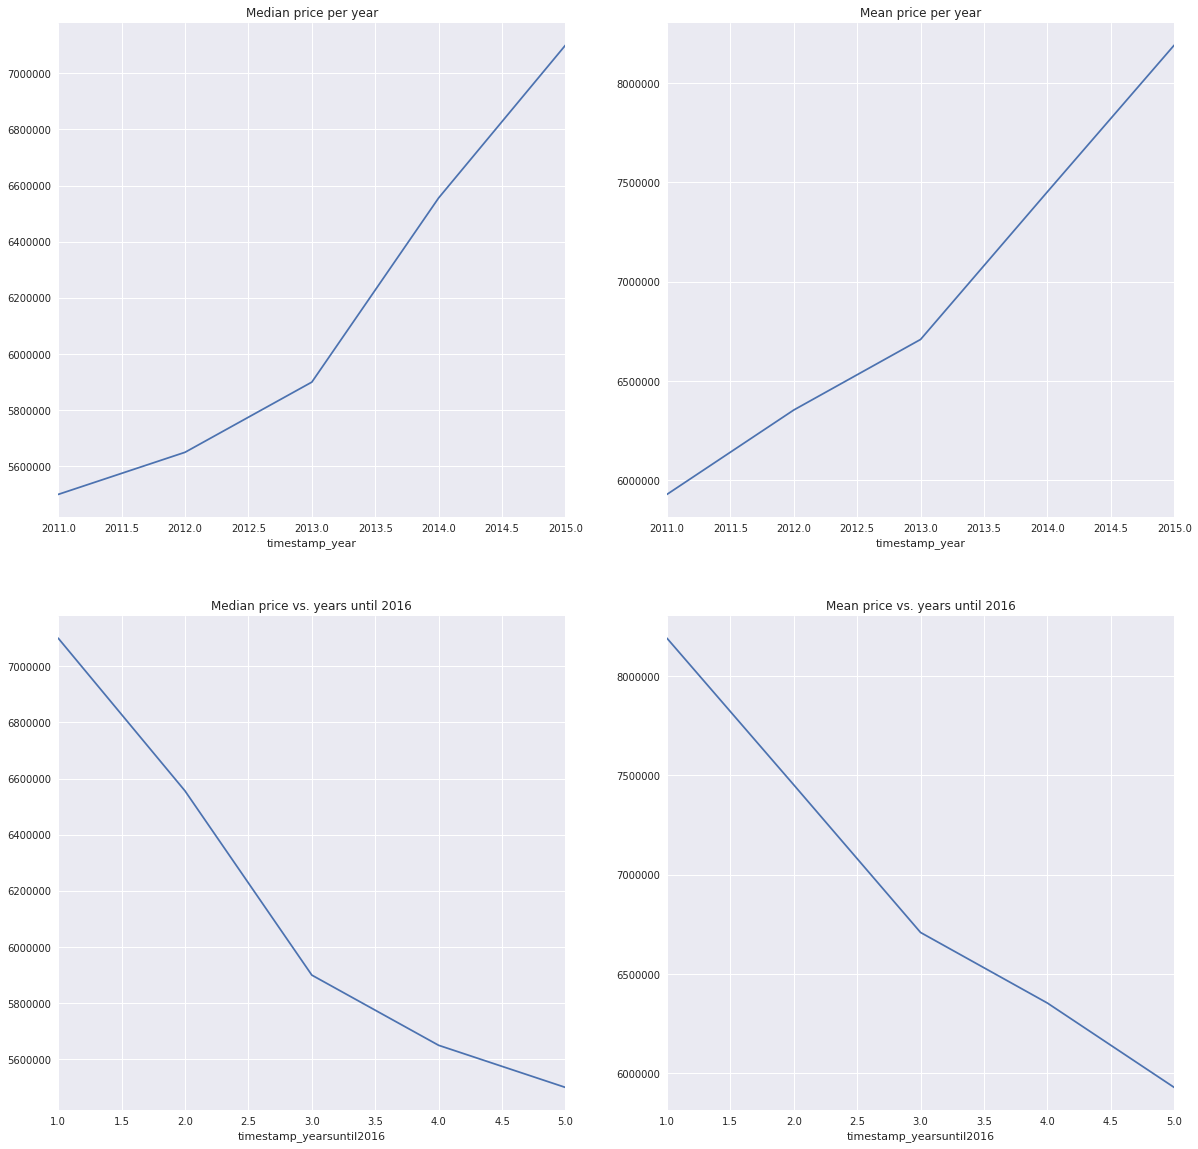

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
full_df_features.groupby('timestamp_year')[LABEL].median().plot(title='Median price per year', ax=axes[0, 0])
full_df_features.groupby('timestamp_year')[LABEL].mean().plot(title='Mean price per year', ax=axes[0, 1])

full_df_features.groupby('timestamp_yearsuntil2016')[LABEL].median().plot(title='Median price vs. years until 2016', ax=axes[1, 0])
full_df_features.groupby('timestamp_yearsuntil2016')[LABEL].mean().plot(title='Mean price vs. years until 2016', ax=axes[1, 1])

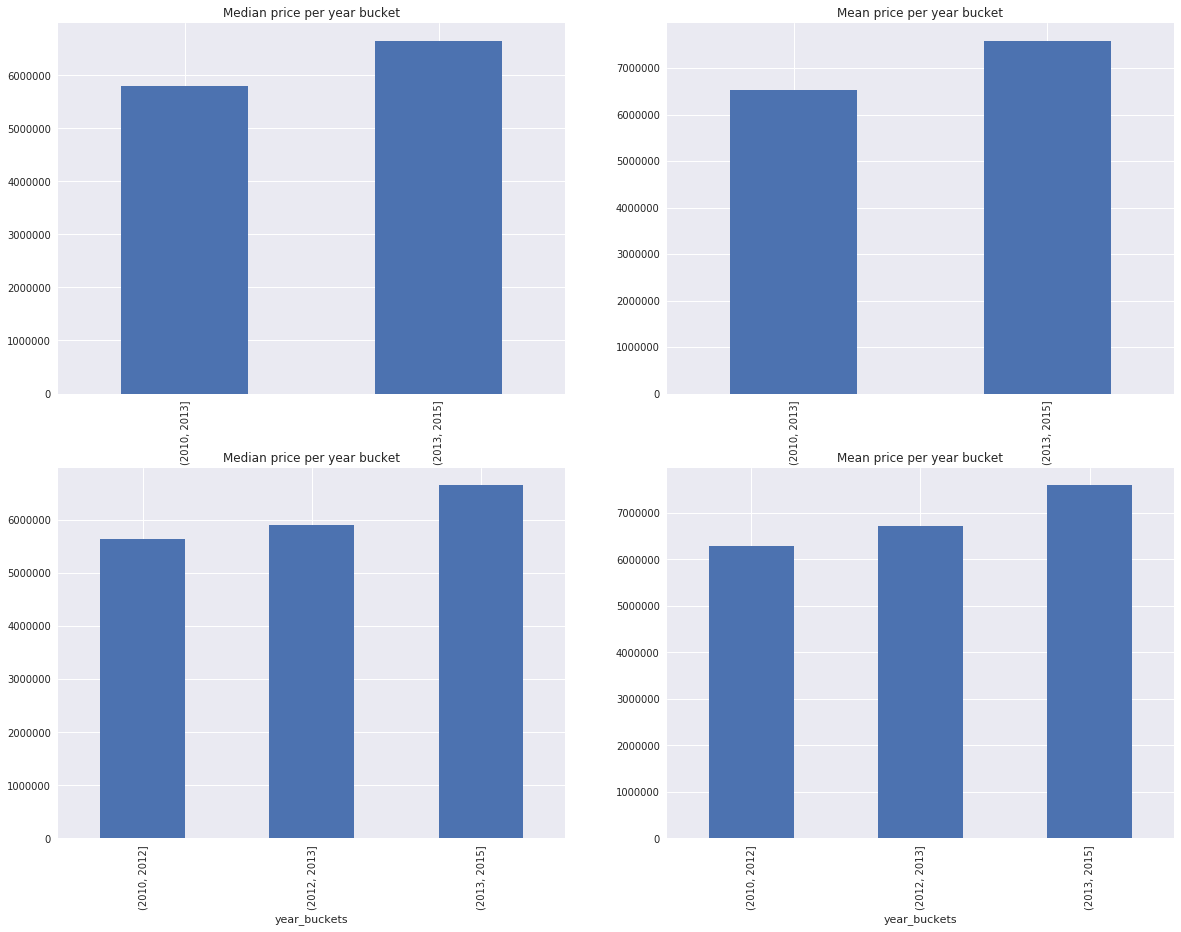

In [31]:
yearbuckets_x_price = pd.DataFrame({'year_buckets' : pd.cut(full_df_features['timestamp_year'], 
                                                            [full_df_features['timestamp_year'].min() - 1,
                                                             2013,
                                                             full_df_features['timestamp_year'].max()]), 
              LABEL: full_df_features[LABEL]}).dropna()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

yearbuckets_x_price.groupby('year_buckets')[LABEL].median().plot(kind='bar', title='Median price per year bucket', ax=axes[0, 0])
yearbuckets_x_price.groupby('year_buckets')[LABEL].mean().plot(kind='bar', title='Mean price per year bucket', ax=axes[0, 1])

yearbuckets_x_price = pd.DataFrame({'year_buckets' : pd.cut(full_df_features['timestamp_year'], 
                                                            [full_df_features['timestamp_year'].min() - 1,
                                                             2012,
                                                             2013,
                                                             full_df_features['timestamp_year'].max()]), 
              LABEL: full_df_features[LABEL]}).dropna()
yearbuckets_x_price.groupby('year_buckets')[LABEL].median().plot(kind='bar', title='Median price per year bucket', ax=axes[1, 0])
yearbuckets_x_price.groupby('year_buckets')[LABEL].mean().plot(kind='bar', title='Mean price per year bucket', ax=axes[1, 1])

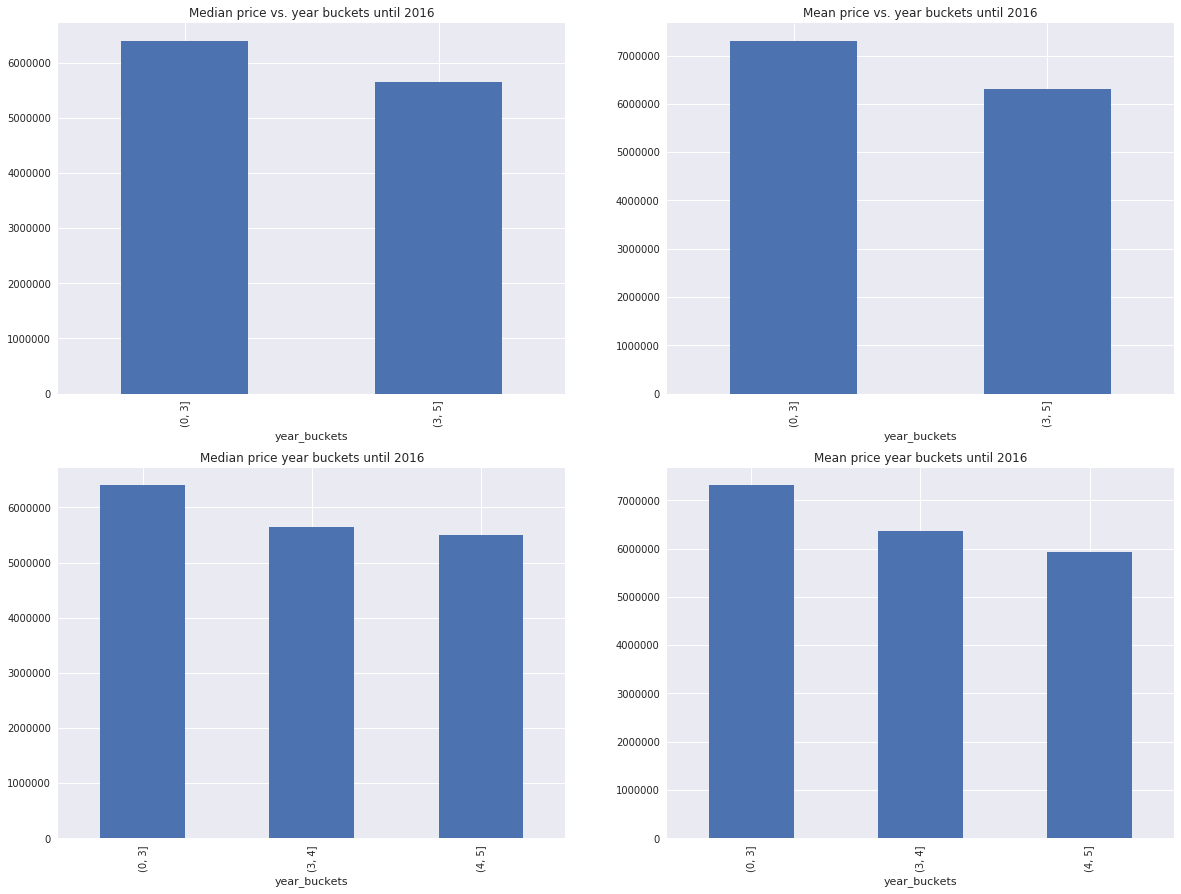

In [34]:
yearbuckets_x_price = pd.DataFrame({'year_buckets' : pd.cut(full_df_features['timestamp_yearsuntil2016'], 
                                                            [full_df_features['timestamp_yearsuntil2016'].min() - 1,
                                                             3,
                                                             full_df_features['timestamp_yearsuntil2016'].max()]), 
              LABEL: full_df_features[LABEL]}).dropna()
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

yearbuckets_x_price.groupby('year_buckets')[LABEL].median().plot(kind='bar', title='Median price vs. year buckets until 2016', ax=axes[0, 0])
yearbuckets_x_price.groupby('year_buckets')[LABEL].mean().plot(kind='bar', title='Mean price vs. year buckets until 2016', ax=axes[0, 1])

yearbuckets_x_price = pd.DataFrame({'year_buckets' : pd.cut(full_df_features['timestamp_yearsuntil2016'], 
                                                            [full_df_features['timestamp_yearsuntil2016'].min() - 1,
                                                             3,
                                                             4,
                                                             full_df_features['timestamp_yearsuntil2016'].max()]), 
              LABEL: full_df_features[LABEL]}).dropna()
yearbuckets_x_price.groupby('year_buckets')[LABEL].median().plot(kind='bar', title='Median price year buckets until 2016', ax=axes[1, 0])
yearbuckets_x_price.groupby('year_buckets')[LABEL].mean().plot(kind='bar', title='Mean price year buckets until 2016', ax=axes[1, 1])

<center>Let's do 2 different cuts in the year data.</center>
One that separates between before 2013 and after 2013, and another one that separates between before 2012, 2012 - 2013, and after 2013.

In [35]:
full_df_features['timestamp_year_bucketized_prepost2013'] = pd.cut(full_df_features['timestamp_year'], [full_df_features['timestamp_year'].min() - 1, 
                                                                                                        2013,
                                                                                                        full_df_features['timestamp_year'].max()])
full_df_features['timestamp_year_bucketized_pre2012post2013'] = pd.cut(full_df_features['timestamp_year'], [full_df_features['timestamp_year'].min() - 1,
                                                                                                            2012,
                                                                                                            2013,
                                                                                                            full_df_features['timestamp_year'].max()])

In [36]:
full_df_features['timestamp_yearsuntil2016_bucketized_prepost2013'] = pd.cut(full_df_features['timestamp_yearsuntil2016'], [full_df_features['timestamp_yearsuntil2016'].min() - 1, 
                                                                                                        3,
                                                                                                        full_df_features['timestamp_yearsuntil2016'].max()])
full_df_features['timestamp_yearsuntil2016_bucketized_pre2012post2013'] = pd.cut(full_df_features['timestamp_yearsuntil2016'], [full_df_features['timestamp_yearsuntil2016'].min() - 1,
                                                                                                            3,
                                                                                                            4,
                                                                                                            full_df_features['timestamp_yearsuntil2016'].max()])

In [56]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_year_bucketized_prepost2013', 'timestamp_year_bucketized_pre2012post2013'])

In [37]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_yearsuntil2016_bucketized_prepost2013', 'timestamp_yearsuntil2016_bucketized_pre2012post2013'])

In [38]:
save_features_to_disk(full_df_features)

<center>How does the price change with respect to ** *leap years* **?</center>

**Observations:**
- The years in the dataset range from 2011 to 2015, and the only leap year in that interval is 2012.
- So, this data ** *would not* ** quantify a relationship between whether a year is a leap year and the average house price, but does show that, when the year is not 2012, prices are generally higher than when a year is 2012. Hmmm... Why would that be?
- Apparently, only the houses sold in February 2012 contained lower prices, so this feature is certainly not reliable for distinguishing between the house prices...

** Warning: **
- This correlation suggests that, if a year is not 2012, then the price will be higher, which is not very reliable and could potentially cause our models to overfit and perform poorly on the private LB.
- Therefore, we ** *should not* ** create a separate feature for this and instead rely on the feature buckets created above, which capture more reliable trends existing within various year intervals.

In [58]:
unreliable_timestamp_features.append('timestamp_isleapyear')

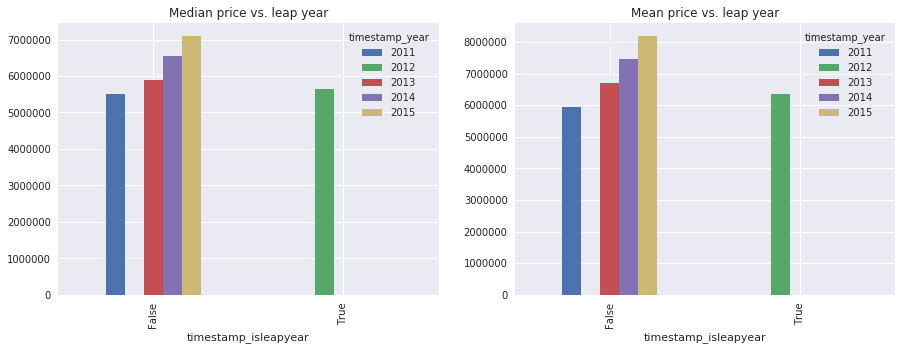

In [59]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby(['timestamp_isleapyear','timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price vs. leap year', ax=axes[0])
full_df_features.groupby(['timestamp_isleapyear','timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price vs. leap year', ax=axes[1])

<center>How does the price change with respect to ** *quarter start/end* **?</center>

**Observations and Warning:**
- This feature does not seem to distinguish well between the prices of a house, and thus, should probably be discarded.

In [60]:
unreliable_timestamp_features += ['timestamp_isquarterstart', 'timestamp_isquarterend']

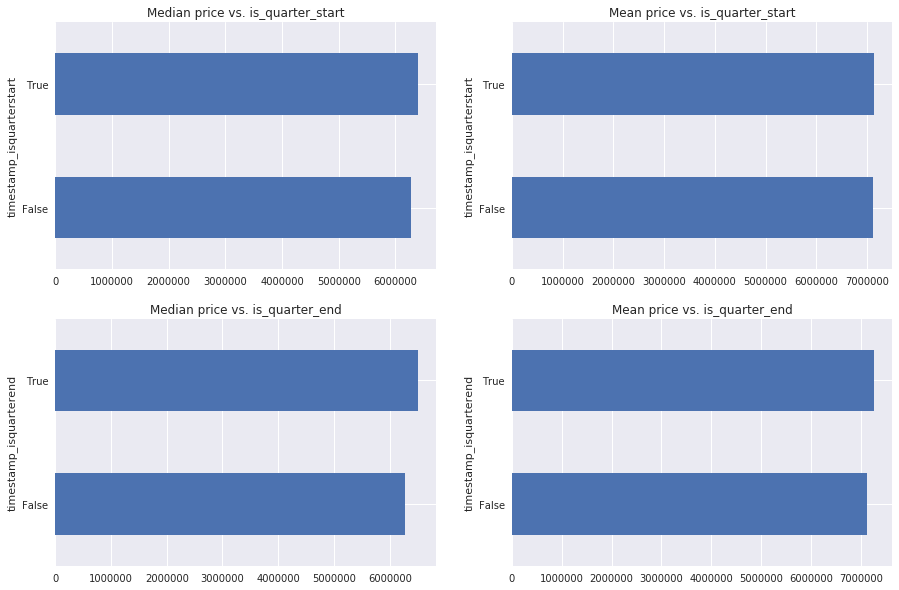

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
full_df_features.groupby('timestamp_isquarterstart')[LABEL].median().plot(kind='barh', title='Median price vs. is_quarter_start', ax=axes[0, 0])
full_df_features.groupby('timestamp_isquarterstart')[LABEL].mean().plot(kind='barh', title='Mean price vs. is_quarter_start', ax=axes[0, 1])

full_df_features.groupby('timestamp_isquarterend')[LABEL].median().plot(kind='barh', title='Median price vs. is_quarter_end', ax=axes[1, 0])
full_df_features.groupby('timestamp_isquarterend')[LABEL].mean().plot(kind='barh', title='Mean price vs. is_quarter_end', ax=axes[1, 1])

<center>How does the price change with respect to ** *year start/end* **?</center>

**Observations and Warning:**
- This feature does not seem to distinguish well between the prices of a house, and thus, should probably be discarded.

In [62]:
unreliable_timestamp_features += ['timestamp_isyearstart', 'timestamp_isyearend']

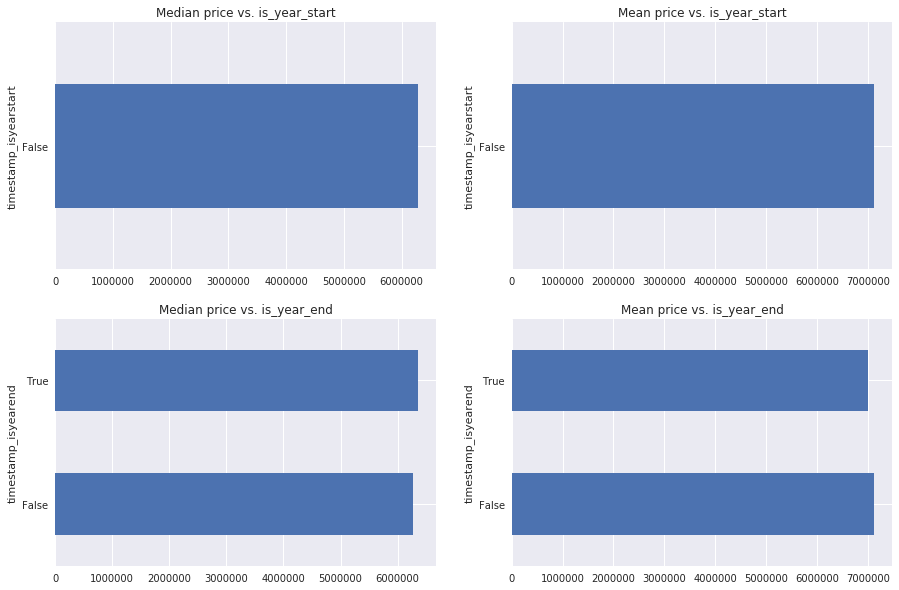

In [63]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
full_df_features.groupby('timestamp_isyearstart')[LABEL].median().plot(kind='barh', title='Median price vs. is_year_start', ax=axes[0, 0])
full_df_features.groupby('timestamp_isyearstart')[LABEL].mean().plot(kind='barh', title='Mean price vs. is_year_start', ax=axes[0, 1])

full_df_features.groupby('timestamp_isyearend')[LABEL].median().plot(kind='barh', title='Median price vs. is_year_end', ax=axes[1, 0])
full_df_features.groupby('timestamp_isyearend')[LABEL].mean().plot(kind='barh', title='Mean price vs. is_year_end', ax=axes[1, 1])

#### Days

In [64]:
SATURDAY, SUNDAY = 5, 6 # Pandas's weekday codes for the weekend

In [65]:
full_df_features['timestamp_dayofweek'] = full_df_features.apply(lambda row: row['timestamp'].dayofweek, axis=1)

In [66]:
full_df_features['timestamp_isweekday'] = full_df_features.apply(lambda row: row['timestamp'].weekday() not in (SATURDAY, SUNDAY), axis=1)

In [67]:
full_df_features['timestamp_dayofmonth'] = full_df_features.apply(lambda row: row['timestamp'].day, axis=1)

In [68]:
full_df_features['timestamp_daysinmonth'] = full_df_features.apply(lambda row: row['timestamp'].daysinmonth, axis=1)

In [69]:
full_df_features['timestamp_dayofyear'] = full_df_features.apply(lambda row: row['timestamp'].dayofyear, axis=1)

In [70]:
# Add the relations of these features to the useful transformed target variables...
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_dayofweek', 'timestamp_isweekday', 'timestamp_dayofmonth', 'timestamp_daysinmonth', 'timestamp_dayofyear'])

#### <center>Analysis + Bucketization + Relations with target variable</center>

<center>How does the price change with respect to the ** *day of the week* **?</center>

**Observations & Warnings:**
- The prices seem to be relatively stable across the days of a week, and thus, this feature should does not distinguish well between the different prices and thus should probably be discarded
- Although the mean house prices seem to decrease near the last few days of the week, the median prices remain relatively stable throughout the week. This effect could be caused by the transaction of those costly 'outlier' prices on the early few days of the week, causing the mean to be higher in this interval and the median to be relatively same.
- Hence, since the ** *median* ** is relatively stable throughout a given week, this feature should probably not be used since it doesn't distinguish well between house prices.
- 

** Notes: **
- Year and day of the week would probably make an interesting ** crossed feature**.
- The **variance** and **standard deviation** of the house prices computed with respect to the year and the day of the week tends to ** *decrease* ** as the week nears its weekend. Perhaps this could make a good feature.

In [71]:
unreliable_timestamp_features.append('timestamp_dayofweek')

In [72]:
crossed_feature_suggestions.append(['timestamp_dayofweek', 'timestamp_year'])

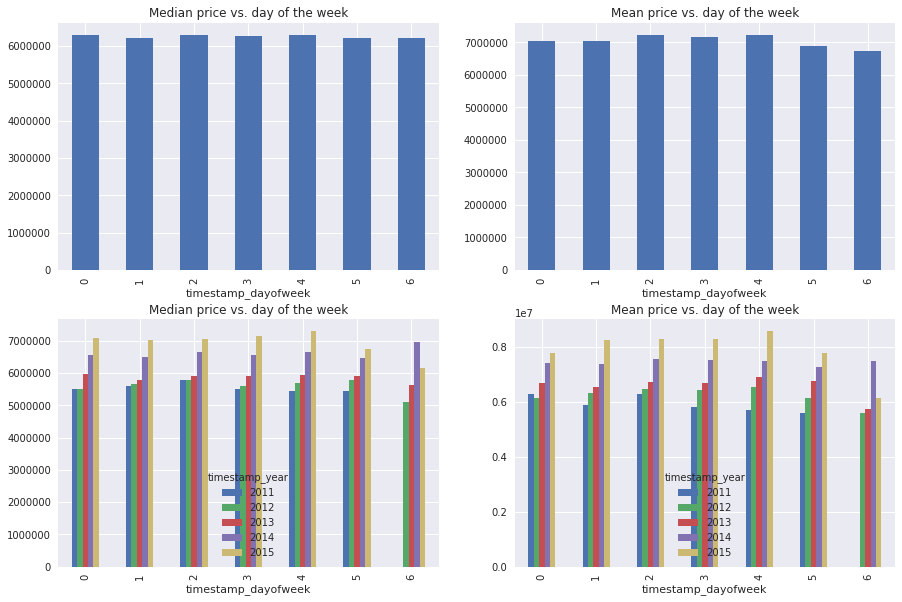

In [73]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

full_df_features.groupby('timestamp_dayofweek')[LABEL].median().plot(kind='bar', title='Median price vs. day of the week', ax=axes[0, 0])
full_df_features.groupby('timestamp_dayofweek')[LABEL].mean().plot(kind='bar', title='Mean price vs. day of the week', ax=axes[0, 1])

full_df_features.groupby(['timestamp_dayofweek','timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price vs. day of the week', ax=axes[1, 0])
full_df_features.groupby(['timestamp_dayofweek','timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price vs. day of the week', ax=axes[1, 1])

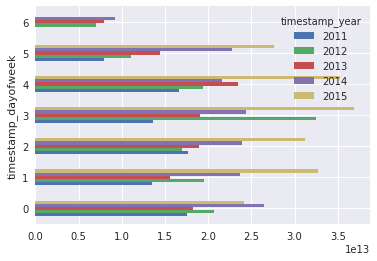

In [74]:
full_df_features.groupby(['timestamp_dayofweek','timestamp_year'])[LABEL].var().unstack().plot(kind='barh')

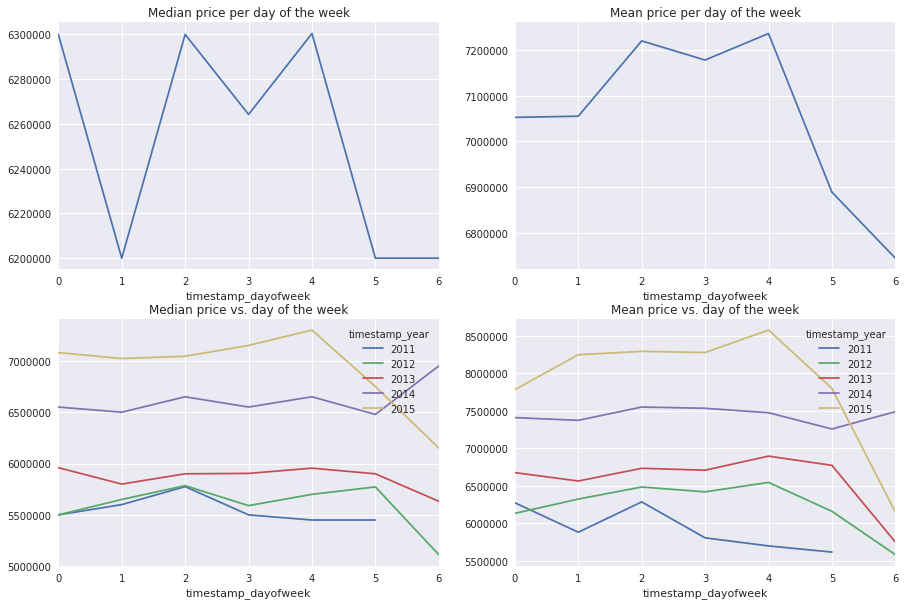

In [75]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

full_df_features.groupby('timestamp_dayofweek')[LABEL].median().plot(title='Median price per day of the week', ax=axes[0, 0])
full_df_features.groupby('timestamp_dayofweek')[LABEL].mean().plot(title='Mean price per day of the week', ax=axes[0, 1])

full_df_features.groupby(['timestamp_dayofweek','timestamp_year'])[LABEL].median().unstack().plot(title='Median price vs. day of the week', ax=axes[1,0])
full_df_features.groupby(['timestamp_dayofweek','timestamp_year'])[LABEL].mean().unstack().plot(title='Mean price vs. day of the week', ax=axes[1,1])

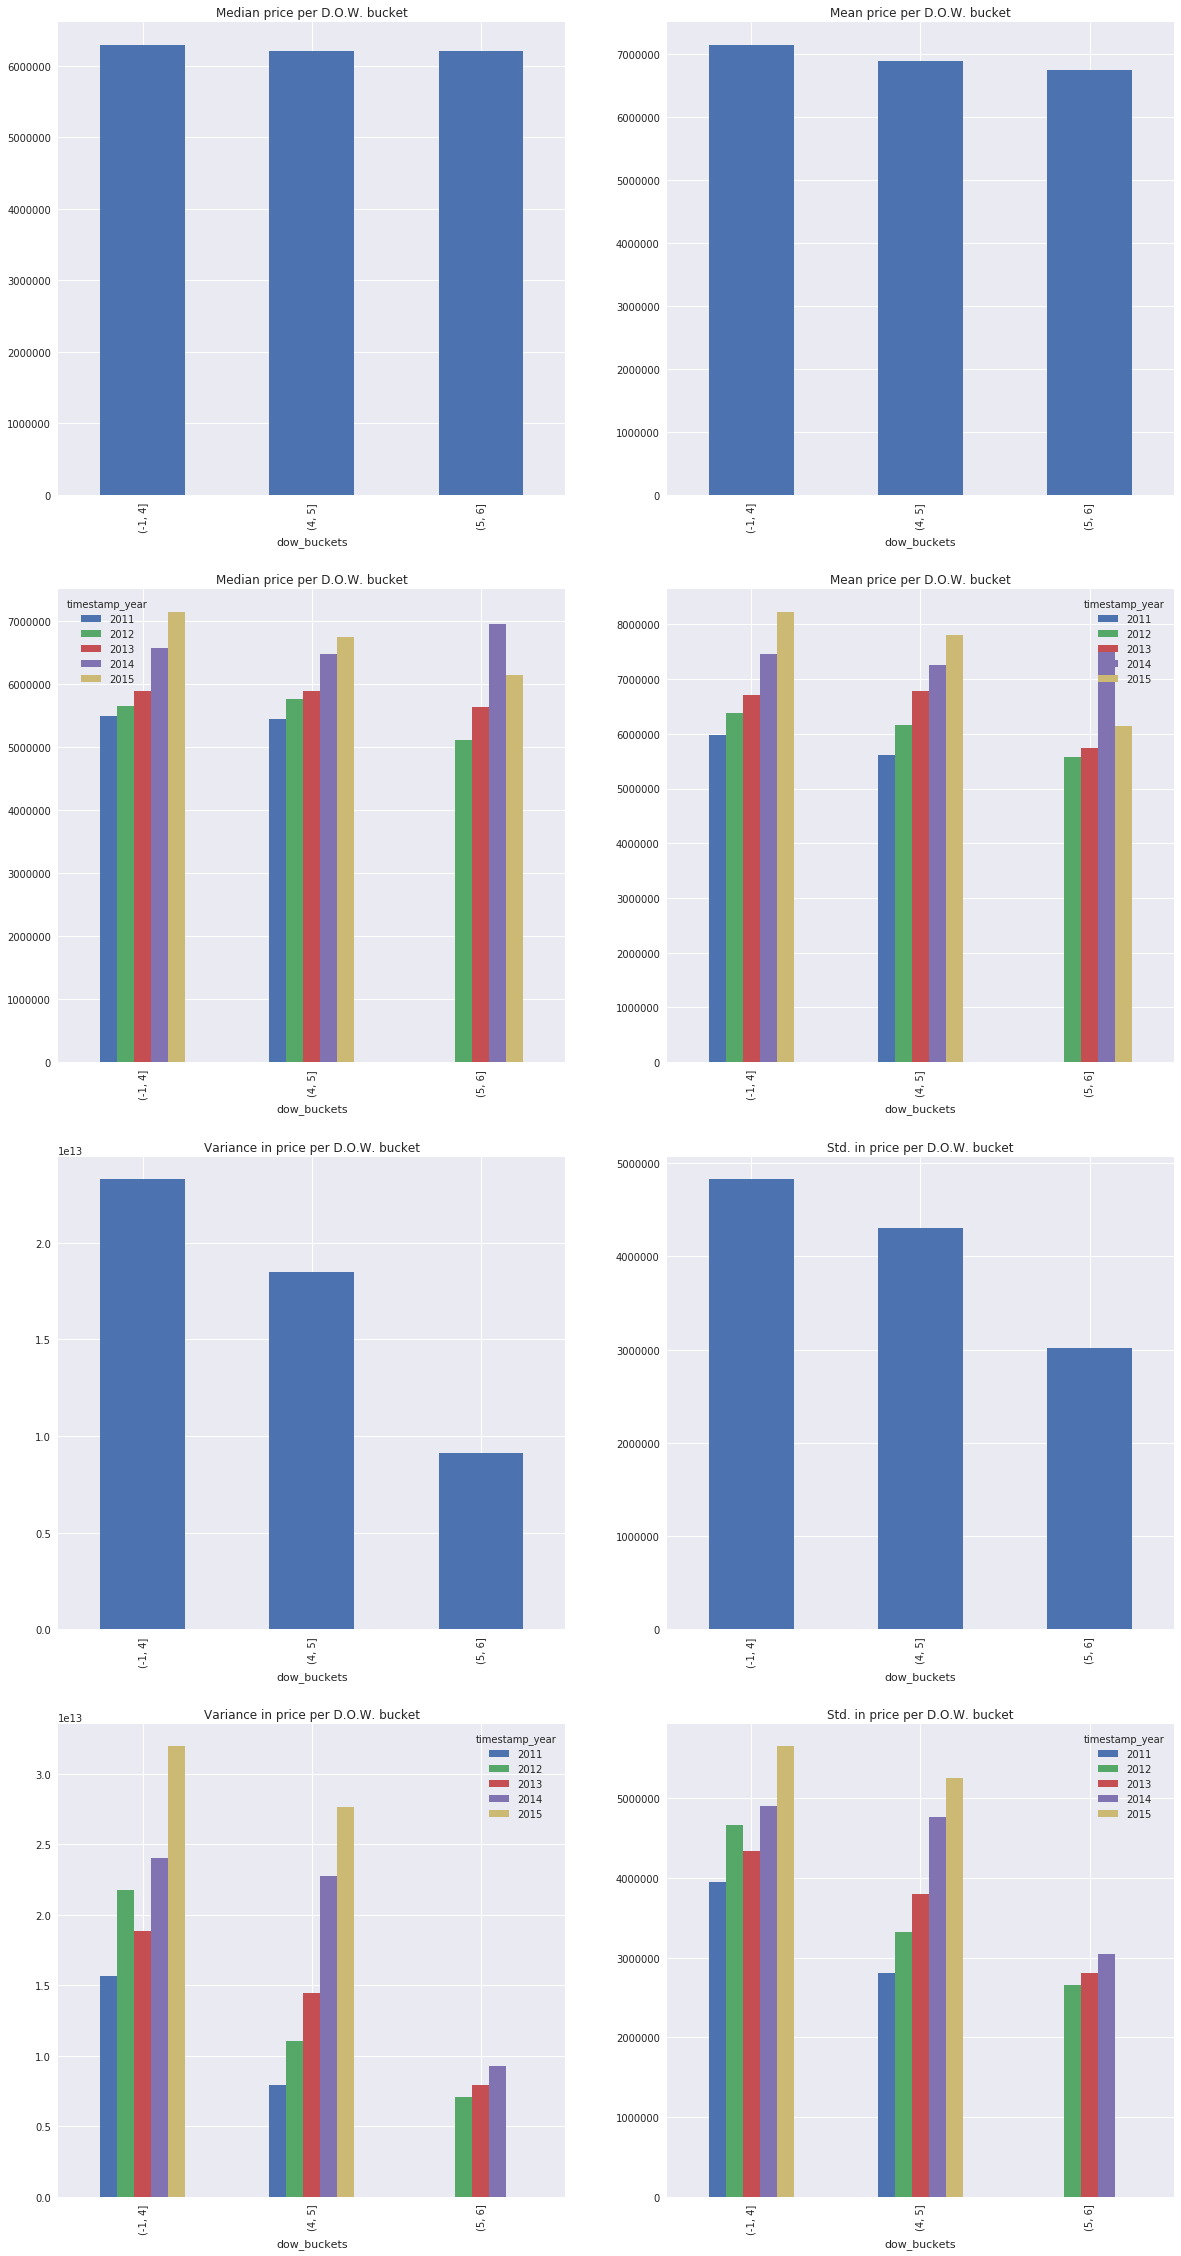

In [76]:
dowbuckets_x_price = pd.DataFrame({'dow_buckets' : pd.cut(full_df_features['timestamp_dayofweek'], 
                                                            [full_df_features['timestamp_dayofweek'].min() - 1,
                                                             4,
                                                             5,
                                                             full_df_features['timestamp_dayofweek'].max()]), 
                                   'timestamp_year' : full_df_features['timestamp_year'],
              LABEL: full_df_features[LABEL]}).dropna()

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 40))

dowbuckets_x_price.groupby('dow_buckets')[LABEL].median().plot(kind='bar', title='Median price per D.O.W. bucket', ax=axes[0, 0])
dowbuckets_x_price.groupby('dow_buckets')[LABEL].mean().plot(kind='bar', title='Mean price per D.O.W. bucket', ax=axes[0, 1])

dowbuckets_x_price.groupby(['dow_buckets','timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price per D.O.W. bucket', ax=axes[1, 0])
dowbuckets_x_price.groupby(['dow_buckets','timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price per D.O.W. bucket', ax=axes[1, 1])

dowbuckets_x_price.groupby('dow_buckets')[LABEL].var().plot(kind='bar', title='Variance in price per D.O.W. bucket', ax=axes[2, 0])
dowbuckets_x_price.groupby('dow_buckets')[LABEL].std().plot(kind='bar', title='Std. in price per D.O.W. bucket', ax=axes[2, 1])

dowbuckets_x_price.groupby(['dow_buckets','timestamp_year'])[LABEL].var().unstack().plot(kind='bar', title='Variance in price per D.O.W. bucket', ax=axes[3, 0])
dowbuckets_x_price.groupby(['dow_buckets','timestamp_year'])[LABEL].std().unstack().plot(kind='bar', title='Std. in price per D.O.W. bucket', ax=axes[3, 1])

In [77]:
full_df_features['timestamp_dayofweek_buckets']  = pd.cut(full_df_features['timestamp_dayofweek'], 
                                                            [full_df_features['timestamp_dayofweek'].min() - 1,
                                                             4,
                                                             5,
                                                             full_df_features['timestamp_dayofweek'].max()])

<center>Let's compute & merge the relations of these buckets to the target variable (including standard deviation and variance), computed with relation to dayofweek buckets and/or year and/or year buckets, with the dataset.</center>

In [78]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_dayofweek_buckets'])

In [79]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_dayofweek_buckets', 'timestamp_year'],])

In [144]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_dayofweek_buckets', 'timestamp_year_bucketized_pre2012post2013']])

In [145]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_dayofweek_buckets', 'timestamp_year_bucketized_prepost2013']])

<center>How does the price change with respect to the ** *weekdays* **?</center>

**Observations & Warnings:**
- This feature doesn't seem to distinguish between the house prices very well, and thus, should probably be discarded.

In [82]:
unreliable_timestamp_features.append('timestamp_isweekday')

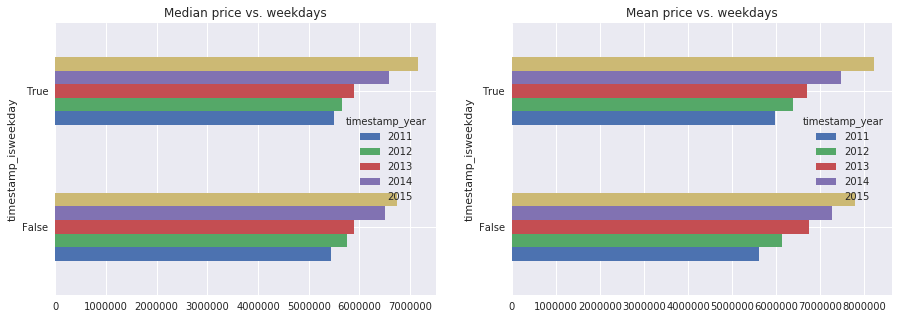

In [81]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

full_df_features.groupby(['timestamp_isweekday','timestamp_year'])[LABEL].median().unstack().plot(kind='barh', title='Median price vs. weekdays', ax=axes[0])
full_df_features.groupby(['timestamp_isweekday','timestamp_year'])[LABEL].mean().unstack().plot(kind='barh', title='Mean price vs. weekdays', ax=axes[1])

<center>How does the price change with respect to the ** *day of the month* **?</center>

**Observations & Warnings:**
- Since the ** *median* ** is relatively stable throughout any given month, this feature should probably not be used since it doesn't distinguish well between house prices.

In [382]:
unreliable_timestamp_features.append('timestamp_dayofmonth')

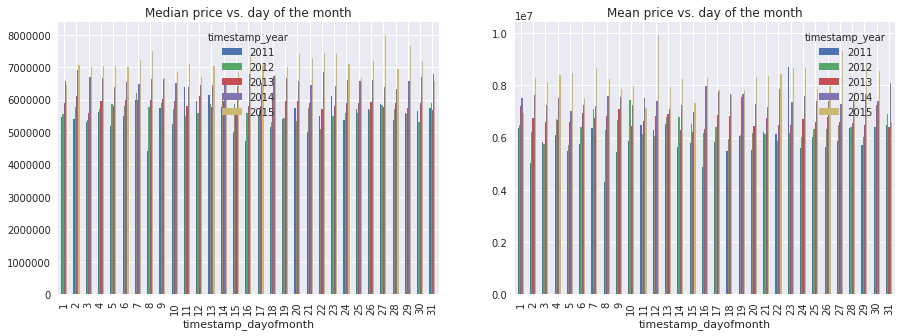

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

full_df_features.groupby(['timestamp_dayofmonth', 'timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price vs. day of the month', ax=axes[0])
full_df_features.groupby(['timestamp_dayofmonth', 'timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price vs. day of the month', ax=axes[1])

2011         Axes(0.1,0.679412;0.363636x0.220588)
2012    Axes(0.536364,0.679412;0.363636x0.220588)
2013         Axes(0.1,0.414706;0.363636x0.220588)
2014    Axes(0.536364,0.414706;0.363636x0.220588)
2015             Axes(0.1,0.15;0.363636x0.220588)
dtype: object

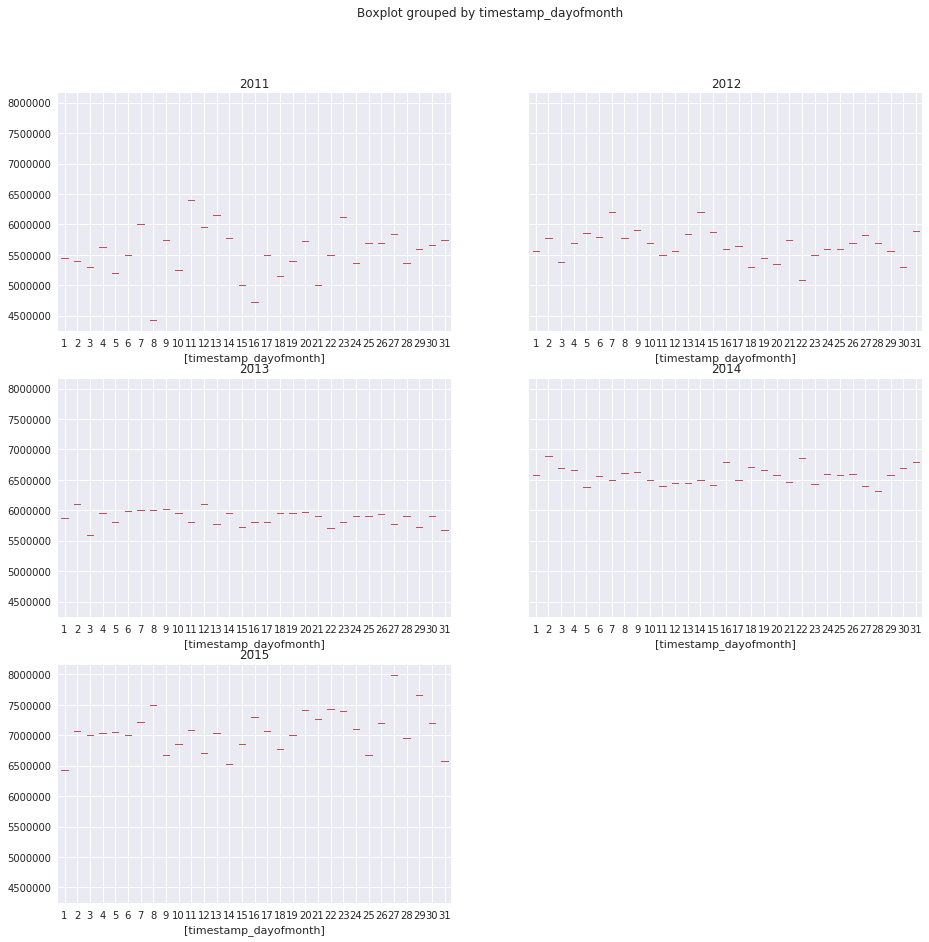

In [133]:
#fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(45, 15))
full_df_features.groupby(['timestamp_dayofmonth', 'timestamp_year'])[LABEL].median().reset_index().groupby('timestamp_year').boxplot(figsize=(15, 15), column=[LABEL], by=['timestamp_dayofmonth'])

2011         Axes(0.1,0.679412;0.363636x0.220588)
2012    Axes(0.536364,0.679412;0.363636x0.220588)
2013         Axes(0.1,0.414706;0.363636x0.220588)
2014    Axes(0.536364,0.414706;0.363636x0.220588)
2015             Axes(0.1,0.15;0.363636x0.220588)
dtype: object

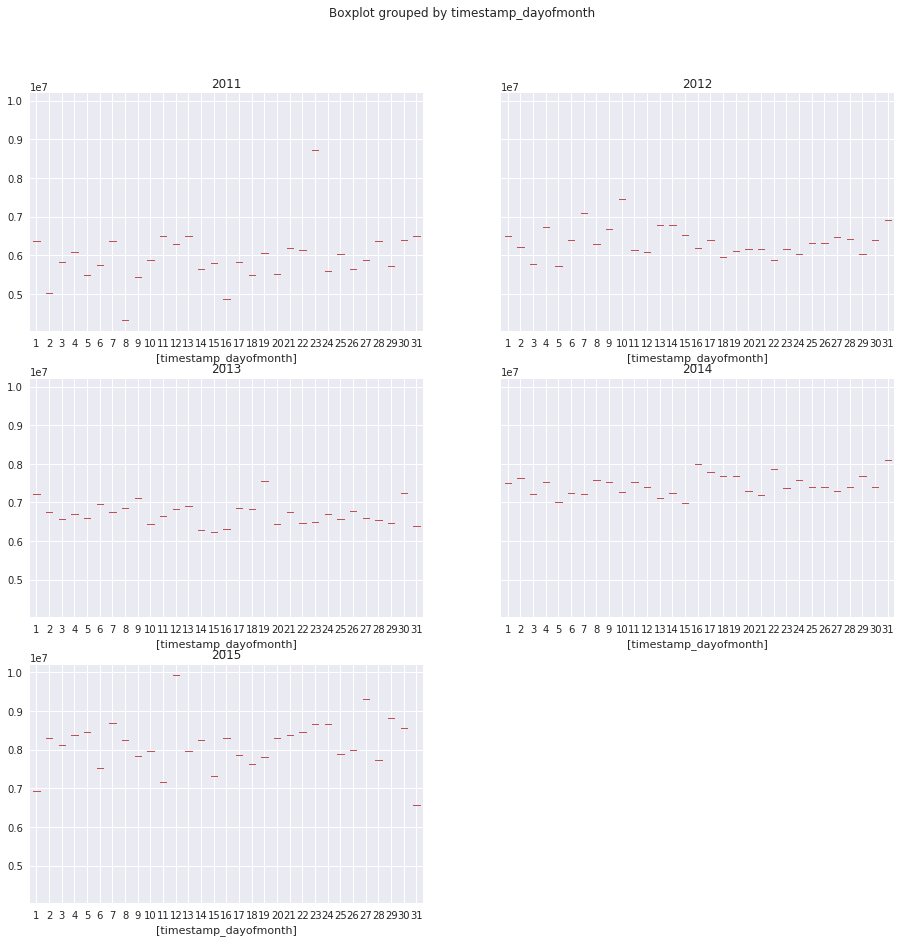

In [134]:
full_df_features.groupby(['timestamp_dayofmonth', 'timestamp_year'])[LABEL].mean().reset_index().groupby('timestamp_year').boxplot(figsize=(15,15), column=[LABEL], by=['timestamp_dayofmonth'])

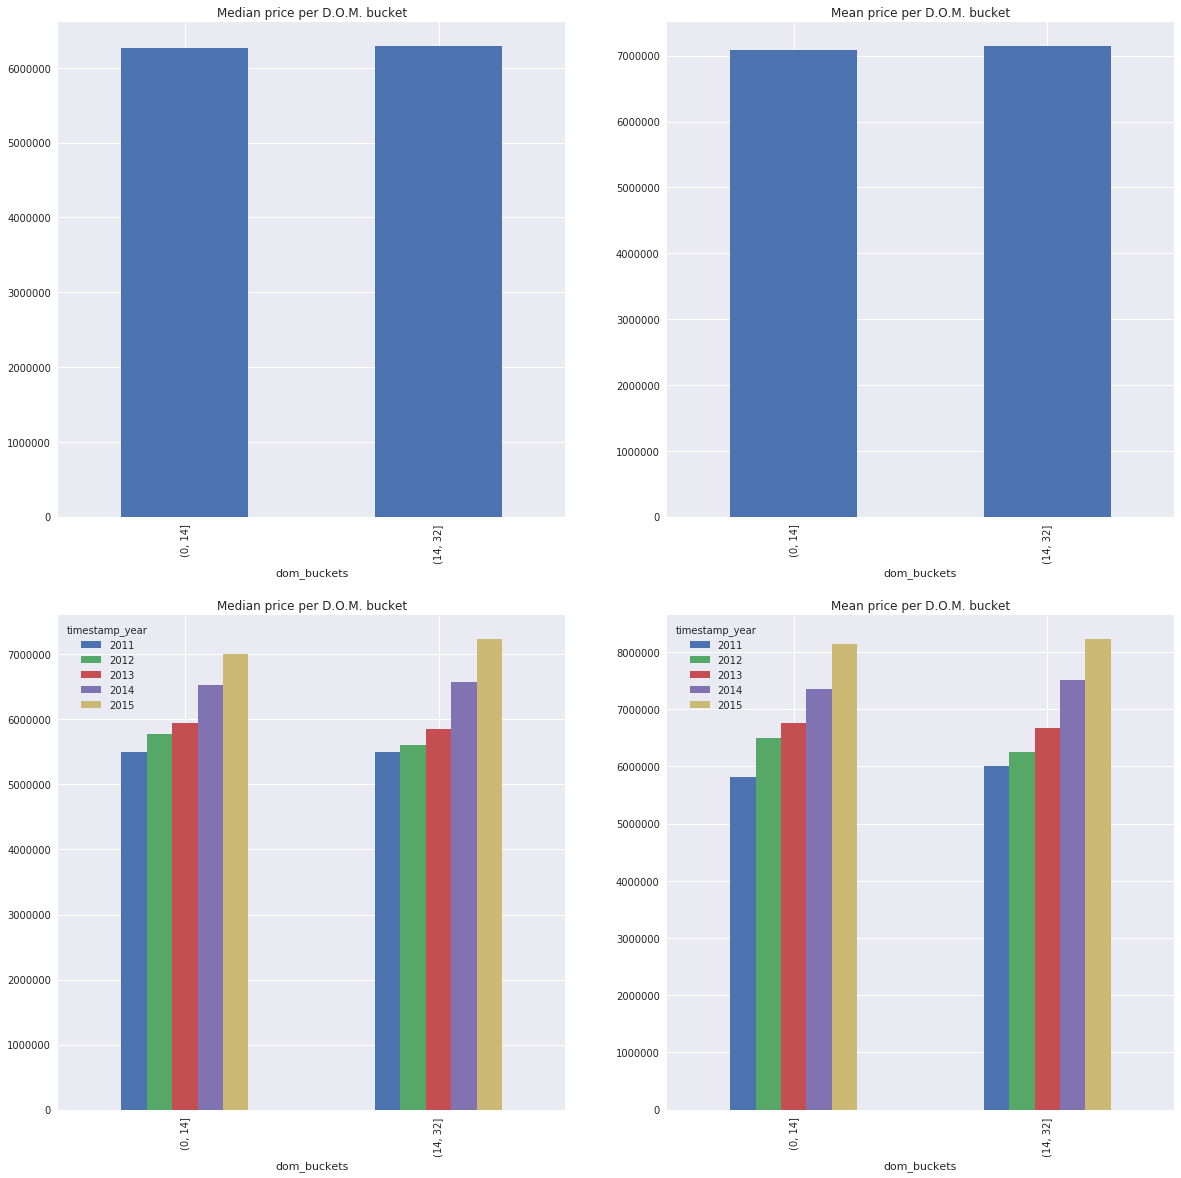

In [153]:
dombuckets_x_price = pd.DataFrame({'dom_buckets' : pd.cut(full_df_features['timestamp_dayofmonth'], 
                                                            [full_df_features['timestamp_dayofmonth'].min() - 1,
                                                             14,
                                                             full_df_features['timestamp_dayofmonth'].max() + 1]), 
                                   'timestamp_year' : full_df_features['timestamp_year'],
                                   LABEL: full_df_features[LABEL]}).dropna()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

dombuckets_x_price.groupby('dom_buckets')[LABEL].median().plot(kind='bar', title='Median price per D.O.M. bucket', ax=axes[0, 0])
dombuckets_x_price.groupby('dom_buckets')[LABEL].mean().plot(kind='bar', title='Mean price per D.O.M. bucket', ax=axes[0, 1])

dombuckets_x_price.groupby(['dom_buckets', 'timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price per D.O.M. bucket', ax=axes[1, 0])
dombuckets_x_price.groupby(['dom_buckets', 'timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price per D.O.M. bucket', ax=axes[1, 1])

In [154]:
full_df_features['timestamp_dom_buckets'] = pd.cut(full_df_features['timestamp_dayofmonth'], 
                                                            [full_df_features['timestamp_dayofmonth'].min() - 1,
                                                             14,
                                                             full_df_features['timestamp_dayofmonth'].max() + 1])

In [155]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_dom_buckets'])

In [156]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_dom_buckets', 'timestamp_year']])

<center>How does the price change with respect to the ** *# days in a month* **?</center>

**Observations & Warnings:**
- There's a *significant* sink ** *only* ** in the house prices of February 2012, a leap year (hence the 29 days...).
- This also explains why we earlier saw that, when a house was sold in a leap year, its price was significantly lower. - Essentially, the houses sold in February of 2012 generally exhibited lower prices.
- However, since this is a **one-time** incident/trend that does not continue, this feature is **unreliable** and thus, should likely not be used.
- Also, the decreasing house price trends of months with 31 days (when compared to the months with 30 days) would probably be better explained and more accuately captured with the months features, not this one.

In [159]:
unreliable_timestamp_features.append('timestamp_daysinmonth')

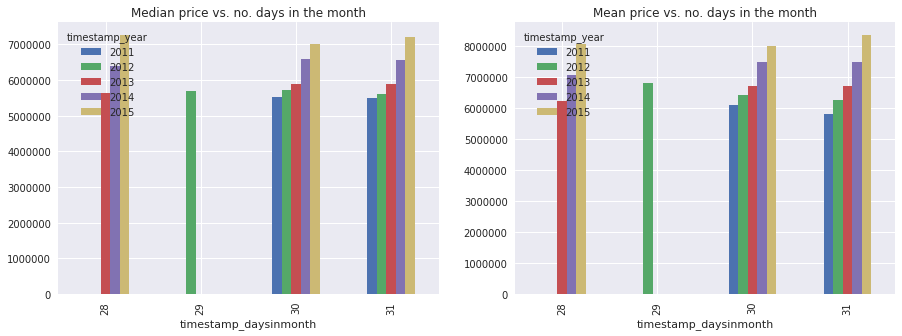

In [157]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby(['timestamp_daysinmonth','timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price vs. no. days in the month', ax=axes[0])
full_df_features.groupby(['timestamp_daysinmonth','timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price vs. no. days in the month', ax=axes[1])

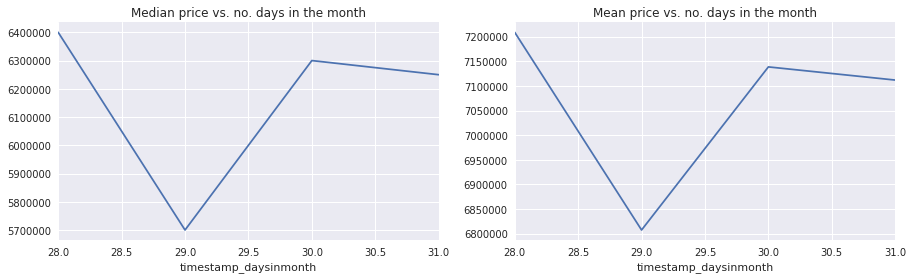

In [158]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
full_df_features.groupby('timestamp_daysinmonth')[LABEL].median().plot(title='Median price vs. no. days in the month', ax=axes[0])
full_df_features.groupby('timestamp_daysinmonth')[LABEL].mean().plot(title='Mean price vs. no. days in the month', ax=axes[1])

In [160]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_daysinmonth'])

In [161]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_daysinmonth', 'timestamp_year']])

In [162]:
save_features_to_disk(full_df_features)

<center>How does the price change with respect to the ** *day of the year* **?</center>

**Observations & Warnings:**

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


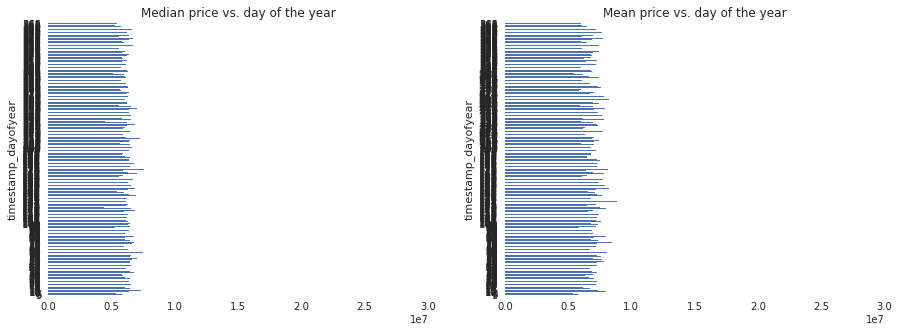

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby('timestamp_dayofyear')[LABEL].median().plot(kind='barh', title='Median price vs. day of the year', ax=axes[0])
full_df_features.groupby('timestamp_dayofyear')[LABEL].mean().plot(kind='barh', title='Mean price vs. day of the year', ax=axes[1])

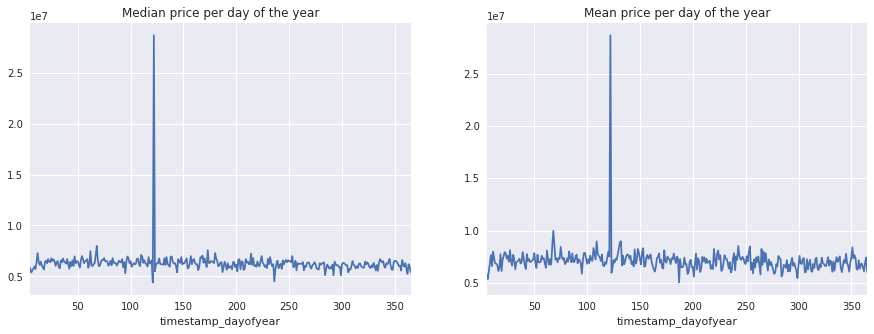

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby('timestamp_dayofyear')[LABEL].median().plot(title='Median price per day of the year', ax=axes[0])
full_df_features.groupby('timestamp_dayofyear')[LABEL].mean().plot(title='Mean price per day of the year', ax=axes[1])

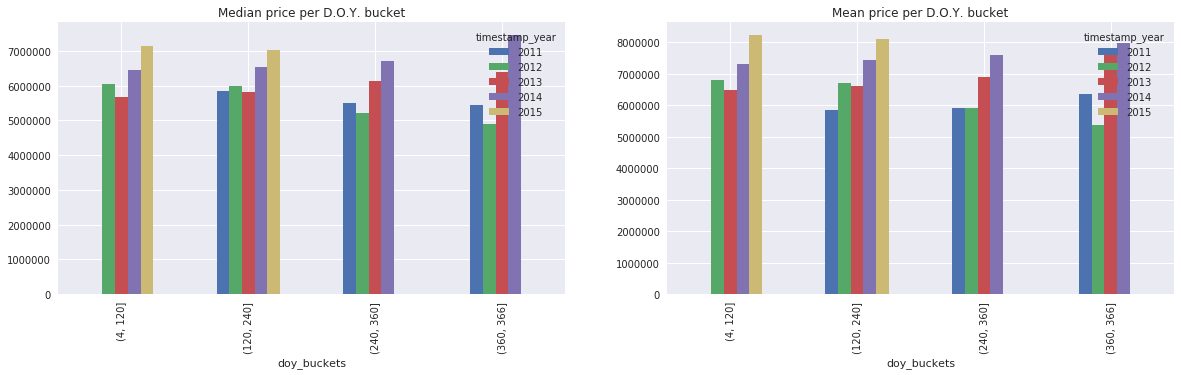

In [16]:
doybuckets_x_price = pd.DataFrame({'doy_buckets' : pd.cut(full_df_features['timestamp_dayofyear'], 
                                                            [full_df_features['timestamp_dayofyear'].min() - 1,
                                                             120,
                                                             240,
                                                             360,
                                                             full_df_features['timestamp_dayofyear'].max() + 1]), 
                                   'timestamp_year' : full_df_features['timestamp_year'],
              LABEL: full_df_features[LABEL]}).dropna()
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

doybuckets_x_price.groupby(['doy_buckets', 'timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price per D.O.Y. bucket', ax=axes[0])
doybuckets_x_price.groupby(['doy_buckets', 'timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price per D.O.Y. bucket', ax=axes[1])

In [19]:
full_df_features['timestamp_doy_buckets'] = pd.cut(full_df_features['timestamp_dayofyear'], 
                                                            [full_df_features['timestamp_dayofyear'].min() - 1,
                                                             120,
                                                             240,
                                                             360,
                                                             full_df_features['timestamp_dayofyear'].max() + 1])

In [20]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_doy_buckets'])

In [21]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_doy_buckets', 'timestamp_year']])

#### Weeks

In [32]:
full_df_features['timestamp_weekofyear'] = full_df_features.apply(lambda row: row['timestamp'].week, axis=1)

#### <center>Analysis + Bucketization + Relations with target variable</center>

<center>How does the price change with respect to the ***week of year***?</center>

**Observations:**

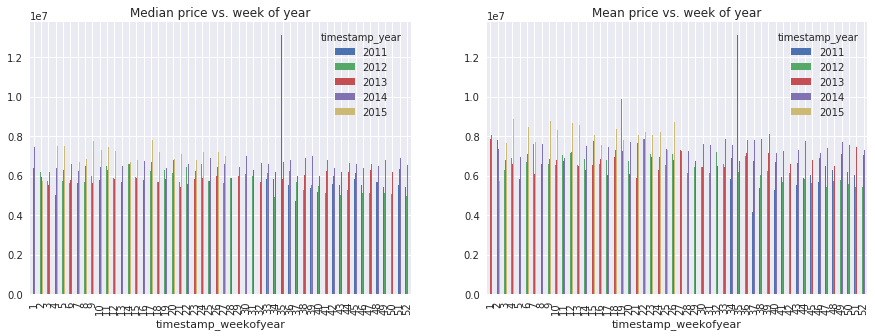

In [50]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby(['timestamp_weekofyear', 'timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price vs. week of year', ax=axes[0])
full_df_features.groupby(['timestamp_weekofyear', 'timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price vs. week of year', ax=axes[1])

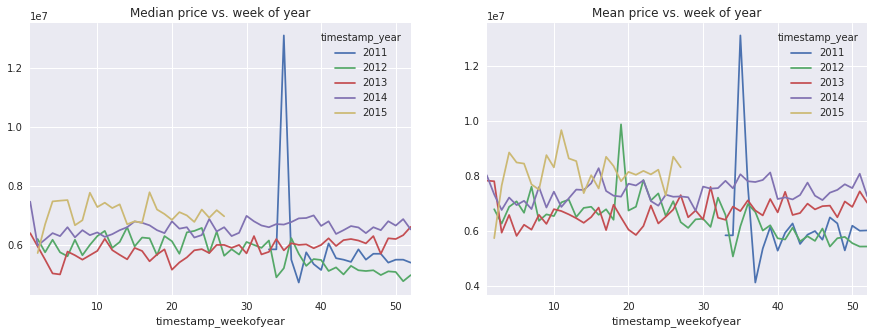

In [54]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
full_df_features.groupby(['timestamp_weekofyear', 'timestamp_year'])[LABEL].median().unstack().plot(title='Median price vs. week of year', ax=axes[0])
full_df_features.groupby(['timestamp_weekofyear', 'timestamp_year'])[LABEL].mean().unstack().plot(title='Mean price vs. week of year', ax=axes[1])

In [55]:
# Add the relations of these features to the target variable...
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, 'timestamp_weekofyear')

In [56]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_weekofyear', 'timestamp_year']])

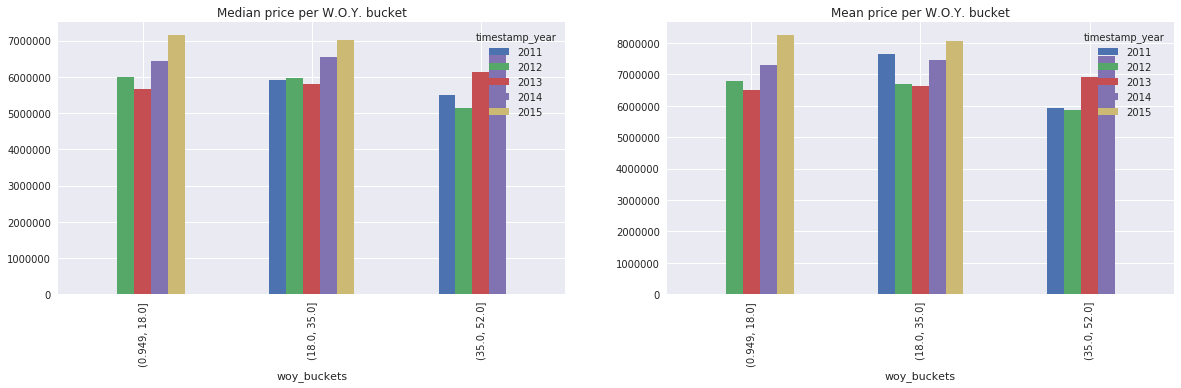

In [66]:
# Both 3 and 4 splits for the woy_buckets seem to be good values, but let's just stick with 3 for now,
# since it's smaller, and thus, captures more information in its intervals.
woybuckets_x_price = pd.DataFrame({'woy_buckets' : pd.cut(full_df_features['timestamp_weekofyear'], 3),
                                   'timestamp_year' : full_df_features['timestamp_year'],
                                   LABEL: full_df_features[LABEL]}).dropna()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

woybuckets_x_price.groupby(['woy_buckets', 'timestamp_year'])[LABEL].median().unstack().plot(kind='bar', title='Median price per W.O.Y. bucket', ax=axes[0])
woybuckets_x_price.groupby(['woy_buckets', 'timestamp_year'])[LABEL].mean().unstack().plot(kind='bar', title='Mean price per W.O.Y. bucket', ax=axes[1])

In [67]:
full_df_features['timestamp_woy_buckets'] = pd.cut(full_df_features['timestamp_weekofyear'], 3)

In [72]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_woy_buckets'])

In [73]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, [['timestamp_woy_buckets', 'timestamp_year']])

In [78]:
save_features_to_disk(full_df_features)

#### Month

In [79]:
full_df_features['timestamp_month'] = full_df_features.apply(lambda row: row['timestamp'].month, axis=1)

In [80]:
full_df_features['timestamp_ismonthstart'] = full_df_features.apply(lambda row: row['timestamp'].is_month_start, axis=1)

In [81]:
full_df_features['timestamp_ismonthend'] = full_df_features.apply(lambda row: row['timestamp'].is_month_end, axis=1)

In [ ]:
# Add the relations of these features to the target variable...
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, ['timestamp_month', 'timestamp_ismonthstart', 'timestamp_ismonthend'])

In [64]:
save_features_to_disk(full_df_features) # Checkpointing our progress, captain! lol.

### Property features
Based on features like full_sq, life_sq, etc.

** Note: ** It would be interesting to also compute some ** *crossed features* ** of the various non-timestamp columns, such as those describing:

    1. property
    2. economy
    3. social atmosphere
    
   *and others*

#### Differences

In [65]:
full_df_features['fullsq_diff_lifesq'] = np.absolute(full_df_features['full_sq'] - full_df_features['life_sq'])

In [66]:
full_df_features['fullsq_diff_kitch_sq'] = np.absolute(full_df_features['full_sq'] - full_df_features['kitch_sq'])

In [67]:
full_df_features['lifesq_diff_kitch_sq'] = np.absolute(full_df_features['life_sq'] - full_df_features['kitch_sq'])

In [68]:
full_df_features['floor_diff_maxfloor'] = np.absolute(full_df_features['max_floor'] - full_df_features['floor'])

In [69]:
full_df_features['timestampyear_diff_buildyear'] = np.absolute(full_df_features['timestamp_year'] - full_df_features['build_year'])

#### Ratios

In [70]:
full_df_features['lifesq_div_full_sq'] = full_df_features['life_sq'] / full_df_features['full_sq']

In [71]:
full_df_features['kitchsq_div_full_sq'] = full_df_features['kitch_sq'] / full_df_features['full_sq']

In [72]:
full_df_features['kitchsq_div_life_sq'] = full_df_features['kitch_sq'] / full_df_features['life_sq']

In [73]:
full_df_features['floor_div_maxfloor'] = full_df_features['floor'] / full_df_features['max_floor']

In [74]:
full_df_features['floor_div_maxfloor'] = full_df_features['floor'] / full_df_features['max_floor']

In [75]:
full_df_features['buildyear_div_timestampyear'] = full_df_features['build_year'] / full_df_features['timestamp_year']

In [76]:
save_features_to_disk(full_df_features)

#### Categorical features and their relations to the target variable

In [77]:
categorical_property_features = ['material', 'state', 'product_type', 'sub_area']

In [78]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, categorical_property_features)

In [79]:
save_features_to_disk(full_df_features)

#### Club infrequent categorical values together

##### Material
Since there's only 1 value for material 3, let's join it with material 6.

In [107]:
full_df_features['material'].value_counts()

1.0    26105
2.0     3419
5.0     1772
4.0     1661
6.0     1021
3.0        1
Name: material, dtype: int64

In [111]:
full_df_features['material_clubbed'] = full_df_features.apply(lambda row: 6.0 if row['material'] == 3.0 else row['material'], axis=1)

In [113]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, 'material_clubbed')

##### State
Since there's only 1 value for state 33.0 and 481 for state 4.0, let's club these two together as one category.

In [115]:
full_df_features['state'].value_counts()

2.0     20810
3.0      6646
1.0      6041
4.0       481
33.0        1
Name: state, dtype: int64

In [116]:
full_df_features['state_clubbed'] = full_df_features.apply(lambda row: 4.0 if row['state'] in (4.0, 33.0) else row['state'], axis=1)

In [119]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, 'state_clubbed')

##### Subarea
The last 8 sub areas (when ordered by decreasing value counts) all have less than 10 counts, so let's club these last 8 together.

In [147]:
full_df_features['sub_area'].value_counts()

Poselenie Sosenskoe               2024
Poselenie Vnukovskoe              1798
Nekrasovka                        1783
Poselenie Moskovskij              1083
Mitino                             759
Poselenie Voskresenskoe            755
Poselenie Filimonkovskoe           589
Mar'ino                            567
Krjukovo                           543
Poselenie Shherbinka               537
Solncevo                           528
Juzhnoe Butovo                     512
Nagatinskij Zaton                  482
Poselenie Desjonovskoe             459
Zapadnoe Degunino                  458
Otradnoe                           404
Nagornoe                           345
Bogorodskoe                        329
Ljublino                           327
Strogino                           323
Izmajlovo                          322
Gol'janovo                         320
Chertanovo Juzhnoe                 313
Tekstil'shhiki                     310
Horoshevo-Mnevniki                 302
Severnoe Tushino         

In [146]:
club_subareas = full_df_features['sub_area'].value_counts().reset_index()[full_df_features['sub_area'].value_counts().reset_index().sub_area < 10]['index'].tolist()
club_subareas

['Vostochnoe',
 'Poselenie Voronovskoe',
 'Poselenie Marushkinskoe',
 'Molzhaninovskoe',
 'Poselenie Shhapovskoe',
 'Poselenie Kievskij',
 'Poselenie Mihajlovo-Jarcevskoe',
 'Poselenie Klenovskoe']

In [148]:
full_df_features['sub_area_clubbed'] = full_df_features.apply(lambda row: "LastEight" if str(row['sub_area']) in club_subareas else row['sub_area'], axis=1)

#### Bucketization

##### full_sq

In [101]:
full_df_features['full_sq'].describe()

count    33979.000000
mean        54.168707
std         36.574313
min          0.000000
25%         38.600000
50%         50.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64

In [195]:
full_sq_ranges = [0, full_df_features['full_sq'].quantile(0.25), full_df_features['full_sq'].quantile(0.75), full_df_features['full_sq'].quantile(0.9), full_df_features['full_sq'].quantile(0.99), full_df_features['full_sq'].max()]
full_sq_ranges

[0, 38.6, 63.0, 79.0, 134.0, 5326.0]

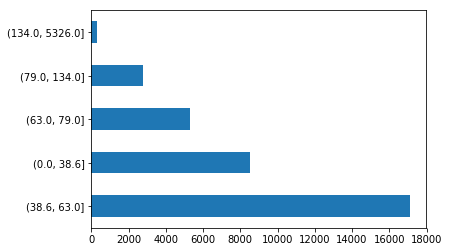

In [198]:
full_df_features['full_sq_bucketized'] = pd.cut(full_df_features['full_sq'], full_sq_ranges)
full_df_features['full_sq_bucketized'].value_counts().plot.barh()

In [207]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, 'full_sq_bucketized')

##### life_sq

In [208]:
full_df_features['life_sq'].describe()

count    33976.000000
mean        33.423760
std         44.779973
min          0.000000
25%         22.000000
50%         30.000000
75%         38.000000
max       7478.000000
Name: life_sq, dtype: float64

In [216]:
life_sq_ranges = [0, full_df_features['life_sq'].quantile(0.25), full_df_features['life_sq'].quantile(0.75), full_df_features['life_sq'].quantile(0.9), full_df_features['life_sq'].quantile(0.99), full_df_features['life_sq'].max()]
life_sq_ranges

[0, 22.0, 38.0, 51.0, 93.4, 7478.0]

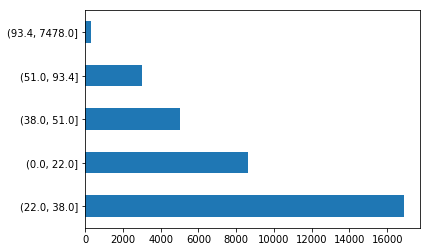

In [220]:
full_df_features['life_sq_bucketized'] = pd.cut(full_df_features['life_sq'], life_sq_ranges)
full_df_features['life_sq_bucketized'].value_counts().plot.barh()

In [221]:
full_df_features = add_relations_to_target_variable_as_feature(full_df_features, 'life_sq_bucketized')

In [222]:
save_features_to_disk(full_df_features)

## Split the fixed dataset into the training and testing subsets

** Note: ** When using the training set as input to machine learning models, remember to only use ONE of the target variable transformations (including the raw target variable itself) and OMIT the others in order to prevent leakage!

** *However* **, make sure to NOT drop the **spl** columns that describe the mean/median target variables in terms of various categorical (or also bucketized) columns!

In [63]:
train_df = df_fixed_imputed[df_fixed_imputed.price_doc.notnull()]
test_df = df_fixed_imputed[df_fixed_imputed.price_doc.isnull()].drop("price_doc", axis=1)

### Also remove any target variable transformation columns from the test set

In [ ]:
for c in test_df.columns.tolist():
    if LABEL in c:
        if 'spl_' not in c:
            print 'Dropping label transformation column, %s, from the test set.' % c
            test_df.drop(c, inplace=True, axis=1)

In [66]:
# Everything's cleaned up! ;)
assert len( train_df.columns[train_df.isnull().any()].tolist()) == 0
assert len( test_df.columns[test_df.isnull().any()].tolist()) == 0